In [1]:
!cp /kaggle/input/nn-utils/* .

In [2]:
!cp /kaggle/input/nn-train-v3/model.weights.h5 .

In [3]:
!pip install tensorflow==2.18.0 keras h5py keras==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.18.0 w

In [4]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

#candles = obj_load("/content/NQ_2")[-100000:]
candles = obj_load("/kaggle/input/us-futures-1-minute-candlesticks/NQ_1")#[50000:]
len(candles)

loading /kaggle/input/us-futures-1-minute-candlesticks/NQ_1


99990

In [5]:
#model = tf.keras.models.load_model("model.keras", safe_mode=False, compile=False)
#model.summary()

In [6]:
 
lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m15 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m15)

chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m5)

chart_m1 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m1)

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m15_at = tf.keras.layers.Concatenate(axis=-1)([chart_m15, pdas_repeated])
m15_at = tf.keras.layers.Dense(512)(concatenated_m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(512)(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(256)(m15_at)
#m15_at = tf.keras.layers.LayerNormalization()(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.LSTM(256, return_sequences=False)(m15_at)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(512)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(512)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(256)(m5_at)
#m5_at = tf.keras.layers.LayerNormalization()(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(256, return_sequences=False)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(512)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(512)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(256)(m1_at)
#m1_at = tf.keras.layers.LayerNormalization()(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(256, return_sequences=False)(m1_at)

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])
#c = tf.keras.layers.Concatenate()([f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])


d = tf.keras.layers.Dense(4096*4)(c)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*1)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)




output = tf.keras.layers.Dense(3, activation="softmax", dtype="float32")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 94)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_11CLONE      │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 60, 94)         │              0 │ input_layer_3[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 60, 98)         │              0 │ keras_tensor_11CLONE[… │
│ (Concatenate)             │                        │                │ lambda_3[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 60, 512)        │         50,688 │ concatenate_2[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 4096)           │              0 │ dense_6[1][0],         │
│                           │                        │                │ dense_7[1][0],         │
│                           │                        │                │ dense_8[1][0],         │
│                           │                        │                │ dense_3[1][0],         │
│                           │                        │                │ dense_4[1][0],         │
│                           │                        │                │ dense_5[1][0],         │
│                           │                        │                │ dense[1][0],           │
│                           │                        │                │ dense_1[1][0],         │
│                           │                        │                │ dense_2[1][0],         │
│                           │                        │                │ dense_9[1][0],         │
│                           │                        │                │ dense_10[1][0],        │
│                           │                        │                │ dense_11[1][0],        │
│                           │                        │                │ dense_12[1][0],        │
│                           │                        │                │ dense_13[1][0],        │
│                           │                        │                │ dense_14[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_7CLONE       │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 60, 512)        │        262,656 │ leaky_re_lu[15][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 98)         │              0 │ keras_tensor_7CLONE[1… │
│ (Concatenate)             │                        │                │ lambda_3[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 60, 256)        │        131,328 │ leaky_re_lu[16][0]     │
├──────────────────────

 Total params: 1,002,140,675 (3.73 GB)

 Trainable params: 1,002,140,675 (3.73 GB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.load_weights("model.weights.h5")

In [8]:

class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction

In [9]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

              
                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 2):
                #equity += open_profit
                #current_position = Position(0,0,0,0)
                #print("close position:", open_profit)
                current_order = None

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 2):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    #sl = entry + avg_candle_range * slm
                    sl = sorted_by_low[2][1]
                    tp = entry  -  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, -1)
                        #print("set short order:",entry,sl,tp)
                    if current_position.direction == -1:
                        #current_position.sl = sl
                        current_position.tp = tp



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 2):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    #sl = entry - avg_candle_range * slm
                    sl = sorted_by_high[2][0]
                    tp = entry  +  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, 1)
                        #print("set long order:",entry,sl,tp)
                    if current_position.direction == 1:
                        #current_position.sl = sl
                        current_position.tp = tp
                        



In [10]:
m = MultiTimeframeCandleManager()

#slm = 2
#tpm = 6

slm = 2
tpm = 6


current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  3%|▎         | 2645/99990 [00:00<00:03, 26448.76it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0.0

 0.0

 0.0

 0.0

 27.0

 -35.75

 -68.0


  5%|▌         | 5311/99990 [00:13<04:39, 338.53it/s]


 -120.75

 -152.5

 -183.0

 -197.75

 -146.70000000000073

 -146.70000000000073

 -43.45000000000073

 -35.95000000000073

 51.04999999999927

 79.29999999999927

 104.79999999999927


  6%|▋         | 6369/99990 [00:30<11:09, 139.79it/s]


 66.04999999999927

 78.04999999999927

 227.04999999999927

 210.04999999999927

 191.04999999999927

 39.54999999999927


  7%|▋         | 6966/99990 [00:39<14:45, 105.05it/s]


 -29.950000000000728

 -29.950000000000728

 -46.20000000000073

 -6.700000000000728


  7%|▋         | 7330/99990 [00:45<16:35, 93.10it/s] 


 33.29999999999927

 -28.450000000000728


  8%|▊         | 7565/99990 [00:49<17:43, 86.89it/s]


 -29.700000000000728

 -4.950000000000728


  8%|▊         | 7723/99990 [00:51<18:33, 82.87it/s]


 -9.950000000000728


  8%|▊         | 7907/99990 [00:54<19:42, 77.87it/s]


 20.799999999999272


  8%|▊         | 8001/99990 [00:56<20:31, 74.67it/s]


 75.04999999999927


  8%|▊         | 8109/99990 [00:57<22:17, 68.69it/s]


 48.54999999999927


  8%|▊         | 8213/99990 [00:59<25:11, 60.70it/s]


 109.29999999999927


  8%|▊         | 8311/99990 [01:01<24:31, 62.32it/s]


 153.79999999999927


  8%|▊         | 8409/99990 [01:02<24:29, 62.31it/s]


 12.799999999999272


  9%|▊         | 8507/99990 [01:04<24:53, 61.26it/s]


 -57.70000000000073


  9%|▊         | 8612/99990 [01:05<24:33, 62.02it/s]


 -83.45000000000073


  9%|▊         | 8710/99990 [01:07<24:25, 62.30it/s]


 -102.45000000000073


  9%|▉         | 8807/99990 [01:09<24:38, 61.69it/s]


 -149.95000000000073


  9%|▉         | 8912/99990 [01:10<24:21, 62.34it/s]


 -187.70000000000073


  9%|▉         | 9010/99990 [01:12<24:17, 62.41it/s]


 -202.95000000000073


  9%|▉         | 9108/99990 [01:13<24:23, 62.11it/s]


 -214.20000000000073


  9%|▉         | 9213/99990 [01:15<24:17, 62.30it/s]


 -243.70000000000073


  9%|▉         | 9311/99990 [01:17<24:12, 62.43it/s]


 -253.70000000000073


  9%|▉         | 9409/99990 [01:18<24:10, 62.46it/s]


 -248.20000000000073


 10%|▉         | 9507/99990 [01:20<24:15, 62.16it/s]


 -261.2000000000007


 10%|▉         | 9612/99990 [01:22<24:09, 62.37it/s]


 -309.2000000000007


 10%|▉         | 9710/99990 [01:23<24:01, 62.61it/s]


 -309.2000000000007


 10%|▉         | 9808/99990 [01:25<24:02, 62.50it/s]


 -338.4500000000007


 10%|▉         | 9913/99990 [01:26<23:54, 62.78it/s]


 -342.7000000000007


 10%|█         | 10011/99990 [01:28<23:53, 62.76it/s]


 -361.7000000000007


 10%|█         | 10109/99990 [01:29<24:01, 62.34it/s]


 -317.9500000000007


 10%|█         | 10207/99990 [01:31<24:11, 61.85it/s]


 -334.9500000000007


 10%|█         | 10312/99990 [01:33<23:56, 62.42it/s]


 -327.9500000000007


 10%|█         | 10410/99990 [01:34<23:51, 62.59it/s]


 -245.85000000000218


 11%|█         | 10508/99990 [01:36<23:54, 62.38it/s]


 -228.75000000000364


 11%|█         | 10613/99990 [01:38<23:53, 62.33it/s]


 -228.75000000000364


 11%|█         | 10711/99990 [01:39<23:54, 62.22it/s]


 -228.75000000000364


 11%|█         | 10809/99990 [01:41<23:53, 62.21it/s]


 -293.50000000000364


 11%|█         | 10907/99990 [01:42<23:48, 62.38it/s]


 -293.50000000000364


 11%|█         | 11012/99990 [01:44<23:50, 62.20it/s]


 -293.50000000000364


 11%|█         | 11110/99990 [01:46<23:42, 62.46it/s]


 -293.50000000000364


 11%|█         | 11208/99990 [01:47<23:44, 62.31it/s]


 -255.95000000000437


 11%|█▏        | 11313/99990 [01:49<23:41, 62.39it/s]


 -227.45000000000437


 11%|█▏        | 11411/99990 [01:50<23:43, 62.22it/s]


 -222.20000000000437


 12%|█▏        | 11509/99990 [01:52<23:38, 62.39it/s]


 -212.95000000000437


 12%|█▏        | 11607/99990 [01:54<23:40, 62.23it/s]


 -202.20000000000437


 12%|█▏        | 11712/99990 [01:55<23:29, 62.61it/s]


 -195.82500000000437


 12%|█▏        | 11810/99990 [01:57<23:32, 62.43it/s]


 -204.32500000000437


 12%|█▏        | 11908/99990 [01:58<23:27, 62.57it/s]


 -207.07500000000437


 12%|█▏        | 12013/99990 [02:00<23:26, 62.54it/s]


 -204.57500000000437


 12%|█▏        | 12111/99990 [02:02<23:43, 61.72it/s]


 -140.57500000000437


 12%|█▏        | 12209/99990 [02:03<24:07, 60.64it/s]


 89.8499999999949


 12%|█▏        | 12307/99990 [02:05<23:21, 62.55it/s]


 89.8499999999949


 12%|█▏        | 12412/99990 [02:06<23:27, 62.22it/s]


 89.8499999999949


 13%|█▎        | 12510/99990 [02:08<23:22, 62.38it/s]


 72.5999999999949


 13%|█▎        | 12608/99990 [02:10<23:19, 62.45it/s]


 72.5999999999949


 13%|█▎        | 12713/99990 [02:11<23:18, 62.41it/s]


 72.3499999999949


 13%|█▎        | 12811/99990 [02:13<23:24, 62.08it/s]


 95.0999999999949


 13%|█▎        | 12909/99990 [02:14<23:18, 62.28it/s]


 105.3499999999949


 13%|█▎        | 13007/99990 [02:16<23:25, 61.91it/s]


 144.3499999999949


 13%|█▎        | 13112/99990 [02:18<23:21, 61.97it/s]


 118.3499999999949


 13%|█▎        | 13210/99990 [02:19<23:13, 62.28it/s]


 131.5999999999949


 13%|█▎        | 13308/99990 [02:21<23:07, 62.46it/s]


 135.0999999999949


 13%|█▎        | 13413/99990 [02:23<23:10, 62.26it/s]


 397.92499999999563


 14%|█▎        | 13511/99990 [02:24<23:19, 61.78it/s]


 545.5999999999949


 14%|█▎        | 13609/99990 [02:26<23:05, 62.33it/s]


 545.5999999999949


 14%|█▎        | 13707/99990 [02:27<23:05, 62.28it/s]


 545.5999999999949


 14%|█▍        | 13812/99990 [02:29<23:00, 62.43it/s]


 545.5999999999949


 14%|█▍        | 13910/99990 [02:31<22:51, 62.77it/s]


 659.5999999999949


 14%|█▍        | 14008/99990 [02:32<23:01, 62.23it/s]


 635.8499999999949


 14%|█▍        | 14113/99990 [02:34<23:12, 61.69it/s]


 564.3499999999949


 14%|█▍        | 14211/99990 [02:35<23:15, 61.49it/s]


 622.8499999999949


 14%|█▍        | 14309/99990 [02:37<22:52, 62.43it/s]


 614.5999999999949


 14%|█▍        | 14407/99990 [02:39<22:52, 62.35it/s]


 631.0999999999949


 15%|█▍        | 14512/99990 [02:40<22:50, 62.38it/s]


 550.3499999999949


 15%|█▍        | 14610/99990 [02:42<22:53, 62.17it/s]


 511.0999999999949


 15%|█▍        | 14708/99990 [02:43<22:49, 62.26it/s]


 502.3499999999949


 15%|█▍        | 14813/99990 [02:45<22:35, 62.82it/s]


 529.5999999999949


 15%|█▍        | 14911/99990 [02:47<22:36, 62.72it/s]


 671.0249999999942


 15%|█▌        | 15009/99990 [02:48<22:37, 62.62it/s]


 671.0249999999942


 15%|█▌        | 15107/99990 [02:50<22:32, 62.76it/s]


 617.2749999999942


 15%|█▌        | 15212/99990 [02:51<22:28, 62.89it/s]


 647.7749999999942


 15%|█▌        | 15310/99990 [02:53<22:31, 62.65it/s]


 584.0249999999942


 15%|█▌        | 15408/99990 [02:55<22:31, 62.60it/s]


 617.7499999999927


 16%|█▌        | 15513/99990 [02:56<22:37, 62.24it/s]


 617.7499999999927


 16%|█▌        | 15611/99990 [02:58<22:28, 62.57it/s]


 613.2499999999927


 16%|█▌        | 15709/99990 [02:59<22:29, 62.47it/s]


 555.4999999999927


 16%|█▌        | 15807/99990 [03:01<22:27, 62.45it/s]


 532.7499999999927


 16%|█▌        | 15912/99990 [03:03<22:27, 62.38it/s]


 537.4999999999927


 16%|█▌        | 16010/99990 [03:04<22:28, 62.27it/s]


 527.2499999999927


 16%|█▌        | 16108/99990 [03:06<22:23, 62.45it/s]


 507.4999999999927


 16%|█▌        | 16213/99990 [03:07<22:24, 62.30it/s]


 703.8999999999942


 16%|█▋        | 16311/99990 [03:09<22:20, 62.45it/s]


 499.8999999999942


 16%|█▋        | 16409/99990 [03:11<22:12, 62.73it/s]


 630.1499999999942


 17%|█▋        | 16507/99990 [03:12<22:16, 62.48it/s]


 545.3999999999942


 17%|█▋        | 16612/99990 [03:14<22:39, 61.31it/s]


 431.8999999999942


 17%|█▋        | 16710/99990 [03:15<22:10, 62.60it/s]


 447.5249999999942


 17%|█▋        | 16808/99990 [03:17<22:19, 62.11it/s]


 425.7749999999942


 17%|█▋        | 16913/99990 [03:19<22:16, 62.15it/s]


 374.7749999999942


 17%|█▋        | 17011/99990 [03:20<22:09, 62.41it/s]


 385.2749999999942


 17%|█▋        | 17109/99990 [03:22<22:09, 62.36it/s]


 378.2749999999942


 17%|█▋        | 17207/99990 [03:23<22:06, 62.39it/s]


 398.2749999999942


 17%|█▋        | 17312/99990 [03:25<22:07, 62.29it/s]


 350.0249999999942


 17%|█▋        | 17410/99990 [03:27<22:03, 62.39it/s]


 367.7749999999942


 18%|█▊        | 17508/99990 [03:28<22:02, 62.38it/s]


 342.7749999999942


 18%|█▊        | 17613/99990 [03:30<22:18, 61.53it/s]


 281.0249999999942


 18%|█▊        | 17711/99990 [03:31<22:02, 62.23it/s]


 281.0249999999942


 18%|█▊        | 17809/99990 [03:33<22:00, 62.23it/s]


 281.0249999999942


 18%|█▊        | 17907/99990 [03:35<21:58, 62.27it/s]


 306.0249999999942


 18%|█▊        | 18012/99990 [03:36<21:54, 62.37it/s]


 323.5249999999942


 18%|█▊        | 18110/99990 [03:38<21:57, 62.16it/s]


 354.5249999999942


 18%|█▊        | 18208/99990 [03:39<22:01, 61.90it/s]


 362.2749999999942


 18%|█▊        | 18313/99990 [03:41<21:53, 62.20it/s]


 370.2749999999942


 18%|█▊        | 18411/99990 [03:43<21:45, 62.49it/s]


 392.0249999999942


 19%|█▊        | 18509/99990 [03:44<21:50, 62.16it/s]


 363.0249999999942


 19%|█▊        | 18607/99990 [03:46<21:45, 62.36it/s]


 349.7749999999942


 19%|█▊        | 18712/99990 [03:48<21:50, 62.04it/s]


 349.7749999999942


 19%|█▉        | 18810/99990 [03:49<21:44, 62.25it/s]


 349.7749999999942


 19%|█▉        | 18908/99990 [03:51<21:39, 62.39it/s]


 292.5249999999942


 19%|█▉        | 19013/99990 [03:52<21:36, 62.44it/s]


 259.2749999999942


 19%|█▉        | 19111/99990 [03:54<21:48, 61.79it/s]


 351.7749999999942


 19%|█▉        | 19209/99990 [03:56<21:41, 62.05it/s]


 435.5249999999942


 19%|█▉        | 19307/99990 [03:57<21:36, 62.25it/s]


 355.0249999999942


 19%|█▉        | 19412/99990 [03:59<21:35, 62.20it/s]


 353.5249999999942


 20%|█▉        | 19510/99990 [04:00<21:29, 62.43it/s]


 332.7749999999942


 20%|█▉        | 19608/99990 [04:02<21:22, 62.66it/s]


 314.0249999999942


 20%|█▉        | 19713/99990 [04:04<21:42, 61.62it/s]


 298.0249999999942


 20%|█▉        | 19811/99990 [04:05<21:25, 62.38it/s]


 269.7749999999942


 20%|█▉        | 19909/99990 [04:07<21:23, 62.38it/s]


 272.0249999999942


 20%|██        | 20007/99990 [04:08<21:19, 62.49it/s]


 242.27499999999418


 20%|██        | 20112/99990 [04:10<22:01, 60.44it/s]


 262.0249999999942


 20%|██        | 20210/99990 [04:12<21:15, 62.53it/s]


 229.02499999999418


 20%|██        | 20308/99990 [04:13<21:13, 62.57it/s]


 301.0249999999942


 20%|██        | 20413/99990 [04:15<21:16, 62.34it/s]


 392.3749999999927


 21%|██        | 20511/99990 [04:16<21:12, 62.48it/s]


 392.3749999999927


 21%|██        | 20609/99990 [04:18<21:19, 62.04it/s]


 392.3749999999927


 21%|██        | 20707/99990 [04:20<21:08, 62.51it/s]


 373.1249999999927


 21%|██        | 20812/99990 [04:21<21:16, 62.02it/s]


 373.1249999999927


 21%|██        | 20910/99990 [04:23<21:19, 61.81it/s]


 346.6249999999927


 21%|██        | 21008/99990 [04:24<21:09, 62.23it/s]


 371.34999999999127


 21%|██        | 21113/99990 [04:26<21:11, 62.02it/s]


 381.799999999992


 21%|██        | 21211/99990 [04:28<21:07, 62.17it/s]


 418.299999999992


 21%|██▏       | 21309/99990 [04:29<21:04, 62.25it/s]


 390.549999999992


 21%|██▏       | 21407/99990 [04:31<21:16, 61.57it/s]


 363.299999999992


 22%|██▏       | 21512/99990 [04:33<20:53, 62.59it/s]


 469.7499999999927


 22%|██▏       | 21610/99990 [04:34<21:09, 61.76it/s]


 483.84999999999127


 22%|██▏       | 21708/99990 [04:36<21:03, 61.96it/s]


 321.59999999999127


 22%|██▏       | 21813/99990 [04:37<20:51, 62.45it/s]


 321.59999999999127


 22%|██▏       | 21911/99990 [04:39<20:54, 62.25it/s]


 317.34999999999127


 22%|██▏       | 22009/99990 [04:41<20:46, 62.54it/s]


 278.34999999999127


 22%|██▏       | 22107/99990 [04:42<21:31, 60.32it/s]


 239.59999999999127


 22%|██▏       | 22212/99990 [04:44<21:10, 61.23it/s]


 267.84999999999127


 22%|██▏       | 22310/99990 [04:45<20:44, 62.43it/s]


 241.09999999999127


 22%|██▏       | 22408/99990 [04:47<20:52, 61.96it/s]


 282.84999999999127


 23%|██▎       | 22513/99990 [04:49<20:50, 61.95it/s]


 266.59999999999127


 23%|██▎       | 22611/99990 [04:50<20:38, 62.46it/s]


 270.09999999999127


 23%|██▎       | 22709/99990 [04:52<20:39, 62.33it/s]


 224.34999999999127


 23%|██▎       | 22807/99990 [04:53<20:36, 62.41it/s]


 215.34999999999127


 23%|██▎       | 22912/99990 [04:55<20:39, 62.18it/s]


 226.09999999999127


 23%|██▎       | 23010/99990 [04:57<20:38, 62.15it/s]


 196.59999999999127


 23%|██▎       | 23108/99990 [04:58<20:35, 62.25it/s]


 288.34999999999127


 23%|██▎       | 23213/99990 [05:00<20:32, 62.29it/s]


 255.84999999999127


 23%|██▎       | 23311/99990 [05:01<20:33, 62.19it/s]


 247.84999999999127


 23%|██▎       | 23409/99990 [05:03<20:33, 62.08it/s]


 235.09999999999127


 24%|██▎       | 23507/99990 [05:05<20:34, 61.98it/s]


 271.59999999999127


 24%|██▎       | 23612/99990 [05:06<20:34, 61.87it/s]


 285.09999999999127


 24%|██▎       | 23710/99990 [05:08<20:28, 62.11it/s]


 226.09999999999127


 24%|██▍       | 23808/99990 [05:09<20:36, 61.62it/s]


 260.549999999992


 24%|██▍       | 23913/99990 [05:11<20:34, 61.63it/s]


 227.27499999999054


 24%|██▍       | 24011/99990 [05:13<20:30, 61.72it/s]


 460.8249999999898


 24%|██▍       | 24112/99990 [05:14<21:15, 59.49it/s]


 460.8249999999898


 24%|██▍       | 24209/99990 [05:16<20:25, 61.85it/s]


 460.8249999999898


 24%|██▍       | 24307/99990 [05:18<20:22, 61.90it/s]


 460.8249999999898


 24%|██▍       | 24412/99990 [05:19<20:19, 61.96it/s]


 460.8249999999898


 25%|██▍       | 24510/99990 [05:21<20:09, 62.42it/s]


 556.3249999999898


 25%|██▍       | 24608/99990 [05:22<20:09, 62.33it/s]


 597.7749999999905


 25%|██▍       | 24713/99990 [05:24<20:15, 61.93it/s]


 579.0249999999905


 25%|██▍       | 24811/99990 [05:26<20:05, 62.38it/s]


 569.7749999999905


 25%|██▍       | 24909/99990 [05:27<20:00, 62.55it/s]


 617.7749999999905


 25%|██▌       | 25007/99990 [05:29<19:59, 62.54it/s]


 682.7249999999913


 25%|██▌       | 25112/99990 [05:31<19:57, 62.52it/s]


 682.7249999999913


 25%|██▌       | 25210/99990 [05:32<19:54, 62.62it/s]


 646.9749999999913


 25%|██▌       | 25308/99990 [05:34<19:59, 62.25it/s]


 607.4749999999913


 25%|██▌       | 25413/99990 [05:35<19:49, 62.72it/s]


 607.4749999999913


 26%|██▌       | 25511/99990 [05:37<19:55, 62.32it/s]


 607.4749999999913


 26%|██▌       | 25609/99990 [05:39<19:55, 62.19it/s]


 607.4749999999913


 26%|██▌       | 25707/99990 [05:40<19:49, 62.47it/s]


 560.9749999999913


 26%|██▌       | 25812/99990 [05:42<19:45, 62.59it/s]


 575.2249999999913


 26%|██▌       | 25910/99990 [05:43<19:46, 62.44it/s]


 607.4749999999913


 26%|██▌       | 26008/99990 [05:45<19:41, 62.60it/s]


 579.4749999999913


 26%|██▌       | 26106/99990 [05:47<20:24, 60.35it/s]


 552.4749999999913


 26%|██▌       | 26209/99990 [05:48<19:48, 62.06it/s]


 576.4749999999913


 26%|██▋       | 26307/99990 [05:50<19:46, 62.12it/s]


 500.97499999999127


 26%|██▋       | 26412/99990 [05:51<19:39, 62.39it/s]


 500.97499999999127


 27%|██▋       | 26510/99990 [05:53<19:37, 62.40it/s]


 583.9749999999913


 27%|██▋       | 26608/99990 [05:55<19:40, 62.17it/s]


 495.72499999999127


 27%|██▋       | 26713/99990 [05:56<19:35, 62.36it/s]


 571.4749999999913


 27%|██▋       | 26811/99990 [05:58<19:28, 62.60it/s]


 703.0999999999913


 27%|██▋       | 26909/99990 [05:59<19:32, 62.32it/s]


 703.0999999999913


 27%|██▋       | 27007/99990 [06:01<19:33, 62.22it/s]


 849.5999999999913


 27%|██▋       | 27112/99990 [06:03<19:28, 62.39it/s]


 723.3499999999913


 27%|██▋       | 27210/99990 [06:04<19:32, 62.09it/s]


 714.674999999992


 27%|██▋       | 27308/99990 [06:06<19:31, 62.04it/s]


 730.424999999992


 27%|██▋       | 27413/99990 [06:08<19:26, 62.23it/s]


 716.674999999992


 28%|██▊       | 27511/99990 [06:09<19:26, 62.12it/s]


 690.424999999992


 28%|██▊       | 27609/99990 [06:11<19:28, 61.92it/s]


 686.424999999992


 28%|██▊       | 27707/99990 [06:12<19:23, 62.14it/s]


 659.424999999992


 28%|██▊       | 27812/99990 [06:14<19:29, 61.70it/s]


 627.424999999992


 28%|██▊       | 27910/99990 [06:16<19:16, 62.35it/s]


 581.924999999992


 28%|██▊       | 28008/99990 [06:17<19:11, 62.51it/s]


 567.424999999992


 28%|██▊       | 28113/99990 [06:19<19:42, 60.81it/s]


 471.674999999992


 28%|██▊       | 28211/99990 [06:20<19:09, 62.44it/s]


 476.424999999992


 28%|██▊       | 28309/99990 [06:22<19:18, 61.89it/s]


 429.924999999992


 28%|██▊       | 28407/99990 [06:24<19:11, 62.18it/s]


 465.174999999992


 29%|██▊       | 28512/99990 [06:25<19:08, 62.25it/s]


 435.674999999992


 29%|██▊       | 28610/99990 [06:27<19:06, 62.24it/s]


 432.424999999992


 29%|██▊       | 28708/99990 [06:28<19:05, 62.24it/s]


 438.424999999992


 29%|██▉       | 28813/99990 [06:30<19:18, 61.44it/s]


 457.424999999992


 29%|██▉       | 28911/99990 [06:32<19:16, 61.44it/s]


 415.174999999992


 29%|██▉       | 29009/99990 [06:33<18:58, 62.35it/s]


 429.424999999992


 29%|██▉       | 29107/99990 [06:35<19:06, 61.80it/s]


 467.19999999999345


 29%|██▉       | 29212/99990 [06:37<19:04, 61.86it/s]


 467.19999999999345


 29%|██▉       | 29310/99990 [06:38<19:03, 61.81it/s]


 536.1249999999927


 29%|██▉       | 29408/99990 [06:40<18:56, 62.12it/s]


 573.3749999999927


 30%|██▉       | 29513/99990 [06:41<18:58, 61.92it/s]


 630.6249999999927


 30%|██▉       | 29611/99990 [06:43<18:50, 62.24it/s]


 630.6249999999927


 30%|██▉       | 29709/99990 [06:45<18:56, 61.84it/s]


 630.6249999999927


 30%|██▉       | 29807/99990 [06:46<18:57, 61.72it/s]


 681.9999999999927


 30%|██▉       | 29912/99990 [06:48<18:43, 62.40it/s]


 690.7499999999927


 30%|███       | 30010/99990 [06:49<18:42, 62.35it/s]


 687.2499999999927


 30%|███       | 30106/99990 [06:51<19:10, 60.76it/s]


 705.5999999999913


 30%|███       | 30211/99990 [06:53<18:44, 62.07it/s]


 696.5999999999913


 30%|███       | 30309/99990 [06:54<18:49, 61.67it/s]


 702.3499999999913


 30%|███       | 30407/99990 [06:56<18:42, 61.99it/s]


 665.5999999999913


 31%|███       | 30512/99990 [06:58<18:44, 61.79it/s]


 663.0999999999913


 31%|███       | 30610/99990 [06:59<18:34, 62.27it/s]


 651.8499999999913


 31%|███       | 30708/99990 [07:01<18:34, 62.16it/s]


 596.5999999999913


 31%|███       | 30813/99990 [07:02<18:38, 61.83it/s]


 668.3499999999913


 31%|███       | 30911/99990 [07:04<18:53, 60.94it/s]


 551.0999999999913


 31%|███       | 31009/99990 [07:06<18:34, 61.91it/s]


 543.5999999999913


 31%|███       | 31107/99990 [07:07<18:27, 62.22it/s]


 570.0999999999913


 31%|███       | 31212/99990 [07:09<18:32, 61.82it/s]


 638.3499999999913


 31%|███▏      | 31310/99990 [07:10<18:26, 62.07it/s]


 626.5999999999913


 31%|███▏      | 31408/99990 [07:12<18:23, 62.17it/s]


 623.0999999999913


 32%|███▏      | 31513/99990 [07:14<18:18, 62.34it/s]


 622.0999999999913


 32%|███▏      | 31611/99990 [07:15<18:19, 62.20it/s]


 617.8499999999913


 32%|███▏      | 31709/99990 [07:17<18:16, 62.25it/s]


 677.8499999999913


 32%|███▏      | 31807/99990 [07:18<18:17, 62.15it/s]


 684.3499999999913


 32%|███▏      | 31912/99990 [07:20<18:18, 61.95it/s]


 689.5999999999913


 32%|███▏      | 32010/99990 [07:22<18:18, 61.89it/s]


 730.3499999999913


 32%|███▏      | 32108/99990 [07:23<18:18, 61.80it/s]


 626.8499999999913


 32%|███▏      | 32213/99990 [07:25<18:12, 62.05it/s]


 626.8499999999913


 32%|███▏      | 32311/99990 [07:26<18:04, 62.38it/s]


 626.8499999999913


 32%|███▏      | 32409/99990 [07:28<18:06, 62.19it/s]


 696.8499999999913


 33%|███▎      | 32507/99990 [07:30<18:04, 62.22it/s]


 693.6249999999927


 33%|███▎      | 32612/99990 [07:31<18:05, 62.06it/s]


 693.6249999999927


 33%|███▎      | 32710/99990 [07:33<18:05, 62.00it/s]


 709.1249999999927


 33%|███▎      | 32808/99990 [07:35<18:05, 61.91it/s]


 678.1249999999927


 33%|███▎      | 32913/99990 [07:36<17:59, 62.11it/s]


 665.1249999999927


 33%|███▎      | 33011/99990 [07:38<18:00, 62.00it/s]


 665.1249999999927


 33%|███▎      | 33109/99990 [07:39<17:50, 62.48it/s]


 617.8749999999927


 33%|███▎      | 33207/99990 [07:41<17:58, 61.90it/s]


 585.6249999999927


 33%|███▎      | 33312/99990 [07:43<17:50, 62.30it/s]


 671.8249999999935


 33%|███▎      | 33410/99990 [07:44<17:54, 61.95it/s]


 608.8249999999935


 34%|███▎      | 33508/99990 [07:46<17:53, 61.91it/s]


 608.8249999999935


 34%|███▎      | 33613/99990 [07:47<17:48, 62.15it/s]


 615.5749999999935


 34%|███▎      | 33711/99990 [07:49<17:51, 61.88it/s]


 585.5749999999935


 34%|███▍      | 33809/99990 [07:51<17:42, 62.26it/s]


 553.8249999999935


 34%|███▍      | 33907/99990 [07:52<17:39, 62.38it/s]


 541.8249999999935


 34%|███▍      | 34011/99990 [07:54<18:48, 58.49it/s]


 568.0749999999935


 34%|███▍      | 34109/99990 [07:55<17:55, 61.23it/s]


 555.0749999999935


 34%|███▍      | 34207/99990 [07:57<17:43, 61.88it/s]


 535.5749999999935


 34%|███▍      | 34312/99990 [07:59<17:39, 62.01it/s]


 515.0749999999935


 34%|███▍      | 34410/99990 [08:00<17:34, 62.20it/s]


 503.32499999999345


 35%|███▍      | 34508/99990 [08:02<17:29, 62.37it/s]


 470.82499999999345


 35%|███▍      | 34613/99990 [08:04<17:33, 62.08it/s]


 414.82499999999345


 35%|███▍      | 34711/99990 [08:05<17:28, 62.28it/s]


 398.07499999999345


 35%|███▍      | 34809/99990 [08:07<17:30, 62.05it/s]


 382.82499999999345


 35%|███▍      | 34907/99990 [08:08<17:19, 62.64it/s]


 419.32499999999345


 35%|███▌      | 35012/99990 [08:10<17:19, 62.50it/s]


 459.32499999999345


 35%|███▌      | 35110/99990 [08:12<17:21, 62.28it/s]


 466.32499999999345


 35%|███▌      | 35208/99990 [08:13<17:17, 62.44it/s]


 485.57499999999345


 35%|███▌      | 35313/99990 [08:15<17:16, 62.41it/s]


 476.82499999999345


 35%|███▌      | 35411/99990 [08:16<17:14, 62.41it/s]


 471.32499999999345


 36%|███▌      | 35509/99990 [08:18<17:19, 62.03it/s]


 486.57499999999345


 36%|███▌      | 35607/99990 [08:20<17:14, 62.21it/s]


 538.3249999999935


 36%|███▌      | 35712/99990 [08:21<17:15, 62.07it/s]


 553.7749999999942


 36%|███▌      | 35810/99990 [08:23<17:11, 62.20it/s]


 553.7749999999942


 36%|███▌      | 35908/99990 [08:24<17:13, 62.02it/s]


 553.7749999999942


 36%|███▌      | 36006/99990 [08:26<17:32, 60.81it/s]


 553.7749999999942


 36%|███▌      | 36111/99990 [08:28<17:04, 62.33it/s]


 541.5249999999942


 36%|███▌      | 36209/99990 [08:29<17:04, 62.24it/s]


 527.7749999999942


 36%|███▋      | 36307/99990 [08:31<17:01, 62.34it/s]


 527.7749999999942


 36%|███▋      | 36412/99990 [08:32<17:01, 62.23it/s]


 513.5249999999942


 37%|███▋      | 36510/99990 [08:34<17:08, 61.74it/s]


 530.7749999999942


 37%|███▋      | 36608/99990 [08:36<17:02, 61.96it/s]


 509.2749999999942


 37%|███▋      | 36713/99990 [08:37<16:54, 62.40it/s]


 493.0249999999942


 37%|███▋      | 36811/99990 [08:39<16:55, 62.20it/s]


 472.7749999999942


 37%|███▋      | 36909/99990 [08:40<16:49, 62.51it/s]


 440.2749999999942


 37%|███▋      | 37007/99990 [08:42<16:49, 62.38it/s]


 425.0249999999942


 37%|███▋      | 37112/99990 [08:44<17:04, 61.39it/s]


 402.7749999999942


 37%|███▋      | 37210/99990 [08:45<16:52, 61.98it/s]


 396.0249999999942


 37%|███▋      | 37308/99990 [08:47<16:48, 62.17it/s]


 444.3499999999949


 37%|███▋      | 37413/99990 [08:49<16:48, 62.04it/s]


 444.3499999999949


 38%|███▊      | 37511/99990 [08:50<16:44, 62.23it/s]


 452.0999999999949


 38%|███▊      | 37609/99990 [08:52<16:38, 62.50it/s]


 443.0999999999949


 38%|███▊      | 37707/99990 [08:53<16:37, 62.46it/s]


 431.3499999999949


 38%|███▊      | 37812/99990 [08:55<16:35, 62.48it/s]


 557.7249999999949


 38%|███▊      | 37910/99990 [08:57<16:35, 62.38it/s]


 557.7249999999949


 38%|███▊      | 38008/99990 [08:58<17:17, 59.72it/s]


 557.7249999999949


 38%|███▊      | 38111/99990 [09:00<16:42, 61.71it/s]


 560.4749999999949


 38%|███▊      | 38209/99990 [09:01<16:38, 61.86it/s]


 651.7249999999949


 38%|███▊      | 38307/99990 [09:03<16:26, 62.53it/s]


 746.5249999999942


 38%|███▊      | 38412/99990 [09:05<16:24, 62.55it/s]


 640.2749999999942


 39%|███▊      | 38510/99990 [09:06<16:28, 62.22it/s]


 640.2749999999942


 39%|███▊      | 38608/99990 [09:08<16:25, 62.30it/s]


 651.6749999999956


 39%|███▊      | 38713/99990 [09:10<16:20, 62.47it/s]


 651.6749999999956


 39%|███▉      | 38811/99990 [09:11<16:23, 62.22it/s]


 651.6749999999956


 39%|███▉      | 38909/99990 [09:13<16:19, 62.35it/s]


 633.4249999999956


 39%|███▉      | 39007/99990 [09:14<16:31, 61.52it/s]


 617.1749999999956


 39%|███▉      | 39112/99990 [09:16<16:27, 61.64it/s]


 669.4249999999956


 39%|███▉      | 39210/99990 [09:18<16:21, 61.92it/s]


 600.7249999999949


 39%|███▉      | 39308/99990 [09:19<16:18, 62.04it/s]


 592.4749999999949


 39%|███▉      | 39413/99990 [09:21<16:12, 62.27it/s]


 604.9749999999949


 40%|███▉      | 39511/99990 [09:22<16:20, 61.71it/s]


 553.7249999999949


 40%|███▉      | 39609/99990 [09:24<16:17, 61.76it/s]


 515.9749999999949


 40%|███▉      | 39707/99990 [09:26<16:10, 62.08it/s]


 515.9749999999949


 40%|███▉      | 39812/99990 [09:27<16:04, 62.38it/s]


 570.9749999999949


 40%|███▉      | 39910/99990 [09:29<16:07, 62.07it/s]


 562.7249999999949


 40%|████      | 40008/99990 [09:30<16:46, 59.60it/s]


 490.7249999999949


 40%|████      | 40112/99990 [09:32<15:56, 62.57it/s]


 490.7249999999949


 40%|████      | 40210/99990 [09:34<16:02, 62.11it/s]


 490.7249999999949


 40%|████      | 40308/99990 [09:35<15:50, 62.77it/s]


 490.7249999999949


 40%|████      | 40413/99990 [09:37<15:52, 62.54it/s]


 501.4749999999949


 41%|████      | 40511/99990 [09:38<15:51, 62.49it/s]


 510.9749999999949


 41%|████      | 40609/99990 [09:40<15:51, 62.44it/s]


 486.4749999999949


 41%|████      | 40707/99990 [09:42<15:50, 62.36it/s]


 458.9749999999949


 41%|████      | 40812/99990 [09:43<15:49, 62.32it/s]


 446.4749999999949


 41%|████      | 40910/99990 [09:45<15:48, 62.30it/s]


 457.4749999999949


 41%|████      | 41008/99990 [09:46<15:45, 62.37it/s]


 428.4749999999949


 41%|████      | 41113/99990 [09:48<15:43, 62.38it/s]


 428.4749999999949


 41%|████      | 41211/99990 [09:50<15:44, 62.20it/s]


 429.9749999999949


 41%|████▏     | 41309/99990 [09:51<15:41, 62.30it/s]


 464.4749999999949


 41%|████▏     | 41407/99990 [09:53<15:47, 61.86it/s]


 595.2249999999949


 42%|████▏     | 41512/99990 [09:55<15:41, 62.13it/s]


 579.7249999999949


 42%|████▏     | 41610/99990 [09:56<15:41, 62.02it/s]


 539.0499999999956


 42%|████▏     | 41708/99990 [09:58<15:32, 62.51it/s]


 480.04999999999563


 42%|████▏     | 41813/99990 [09:59<15:31, 62.47it/s]


 480.04999999999563


 42%|████▏     | 41911/99990 [10:01<15:28, 62.52it/s]


 462.29999999999563


 42%|████▏     | 42009/99990 [10:03<15:59, 60.44it/s]


 455.04999999999563


 42%|████▏     | 42107/99990 [10:04<15:55, 60.61it/s]


 456.54999999999563


 42%|████▏     | 42212/99990 [10:06<15:28, 62.23it/s]


 481.54999999999563


 42%|████▏     | 42310/99990 [10:07<15:21, 62.57it/s]


 437.04999999999563


 42%|████▏     | 42408/99990 [10:09<15:23, 62.33it/s]


 512.7499999999964


 43%|████▎     | 42513/99990 [10:11<15:37, 61.32it/s]


 480.24999999999636


 43%|████▎     | 42611/99990 [10:12<15:27, 61.89it/s]


 506.24999999999636


 43%|████▎     | 42709/99990 [10:14<15:34, 61.29it/s]


 457.24999999999636


 43%|████▎     | 42807/99990 [10:15<15:21, 62.03it/s]


 679.2999999999956


 43%|████▎     | 42912/99990 [10:17<15:22, 61.88it/s]


 668.2999999999956


 43%|████▎     | 43010/99990 [10:19<15:21, 61.84it/s]


 652.5499999999956


 43%|████▎     | 43108/99990 [10:20<15:17, 62.02it/s]


 640.3249999999971


 43%|████▎     | 43213/99990 [10:22<15:16, 61.93it/s]


 640.3249999999971


 43%|████▎     | 43311/99990 [10:24<15:12, 62.14it/s]


 604.8249999999971


 43%|████▎     | 43409/99990 [10:25<15:19, 61.54it/s]


 604.8249999999971


 44%|████▎     | 43507/99990 [10:27<15:05, 62.39it/s]


 602.8249999999971


 44%|████▎     | 43612/99990 [10:28<15:05, 62.24it/s]


 581.3249999999971


 44%|████▎     | 43710/99990 [10:30<15:07, 62.04it/s]


 607.8249999999971


 44%|████▍     | 43808/99990 [10:32<15:01, 62.32it/s]


 620.6999999999971


 44%|████▍     | 43913/99990 [10:33<15:00, 62.30it/s]


 587.9499999999971


 44%|████▍     | 44013/99990 [10:35<15:21, 60.72it/s]


 603.4499999999971


 44%|████▍     | 44111/99990 [10:37<14:55, 62.41it/s]


 530.6999999999971


 44%|████▍     | 44209/99990 [10:38<14:52, 62.53it/s]


 530.6999999999971


 44%|████▍     | 44307/99990 [10:40<14:50, 62.51it/s]


 471.4499999999971


 44%|████▍     | 44412/99990 [10:41<14:44, 62.86it/s]


 471.4499999999971


 45%|████▍     | 44510/99990 [10:43<14:44, 62.69it/s]


 446.9499999999971


 45%|████▍     | 44608/99990 [10:44<14:53, 61.98it/s]


 427.4499999999971


 45%|████▍     | 44713/99990 [10:46<14:40, 62.75it/s]


 578.2499999999964


 45%|████▍     | 44811/99990 [10:48<14:43, 62.43it/s]


 606.2499999999964


 45%|████▍     | 44909/99990 [10:49<14:38, 62.71it/s]


 561.4999999999964


 45%|████▌     | 45007/99990 [10:51<14:40, 62.44it/s]


 516.7499999999964


 45%|████▌     | 45112/99990 [10:52<14:31, 62.94it/s]


 516.7499999999964


 45%|████▌     | 45210/99990 [10:54<14:40, 62.19it/s]


 516.7499999999964


 45%|████▌     | 45308/99990 [10:56<14:34, 62.53it/s]


 516.7499999999964


 45%|████▌     | 45413/99990 [10:57<14:32, 62.58it/s]


 515.4999999999964


 46%|████▌     | 45511/99990 [10:59<14:36, 62.13it/s]


 487.24999999999636


 46%|████▌     | 45609/99990 [11:00<14:39, 61.81it/s]


 487.24999999999636


 46%|████▌     | 45707/99990 [11:02<14:33, 62.15it/s]


 487.24999999999636


 46%|████▌     | 45812/99990 [11:04<14:39, 61.57it/s]


 475.99999999999636


 46%|████▌     | 45910/99990 [11:05<14:29, 62.23it/s]


 454.49999999999636


 46%|████▌     | 46008/99990 [11:07<14:36, 61.62it/s]


 487.49999999999636


 46%|████▌     | 46113/99990 [11:09<14:24, 62.30it/s]


 533.4999999999964


 46%|████▌     | 46211/99990 [11:10<14:29, 61.86it/s]


 603.0999999999985


 46%|████▋     | 46309/99990 [11:12<14:22, 62.24it/s]


 481.09999999999854


 46%|████▋     | 46407/99990 [11:13<14:43, 60.68it/s]


 502.59999999999854


 47%|████▋     | 46512/99990 [11:15<14:12, 62.74it/s]


 502.59999999999854


 47%|████▋     | 46610/99990 [11:17<14:11, 62.71it/s]


 496.34999999999854


 47%|████▋     | 46708/99990 [11:18<14:14, 62.33it/s]


 486.09999999999854


 47%|████▋     | 46813/99990 [11:20<14:16, 62.12it/s]


 441.09999999999854


 47%|████▋     | 46911/99990 [11:21<14:06, 62.67it/s]


 441.09999999999854


 47%|████▋     | 47009/99990 [11:23<14:09, 62.37it/s]


 441.09999999999854


 47%|████▋     | 47107/99990 [11:25<14:05, 62.53it/s]


 435.59999999999854


 47%|████▋     | 47212/99990 [11:26<14:04, 62.52it/s]


 396.59999999999854


 47%|████▋     | 47310/99990 [11:28<14:02, 62.53it/s]


 392.34999999999854


 47%|████▋     | 47408/99990 [11:29<14:00, 62.53it/s]


 411.97499999999854


 48%|████▊     | 47513/99990 [11:31<14:02, 62.26it/s]


 402.72499999999854


 48%|████▊     | 47611/99990 [11:33<14:02, 62.16it/s]


 411.22499999999854


 48%|████▊     | 47709/99990 [11:34<14:02, 62.04it/s]


 451.22499999999854


 48%|████▊     | 47807/99990 [11:36<13:58, 62.27it/s]


 432.3999999999978


 48%|████▊     | 47912/99990 [11:37<13:58, 62.11it/s]


 432.3999999999978


 48%|████▊     | 48007/99990 [11:39<14:15, 60.76it/s]


 415.3999999999978


 48%|████▊     | 48112/99990 [11:41<13:44, 62.91it/s]


 388.3999999999978


 48%|████▊     | 48210/99990 [11:42<13:42, 62.94it/s]


 345.3999999999978


 48%|████▊     | 48308/99990 [11:44<14:01, 61.41it/s]


 345.3999999999978


 48%|████▊     | 48413/99990 [11:46<13:45, 62.46it/s]


 345.3999999999978


 49%|████▊     | 48511/99990 [11:47<13:45, 62.33it/s]


 339.3999999999978


 49%|████▊     | 48609/99990 [11:49<13:43, 62.42it/s]


 321.8999999999978


 49%|████▊     | 48707/99990 [11:50<13:38, 62.62it/s]


 341.8999999999978


 49%|████▉     | 48812/99990 [11:52<13:44, 62.11it/s]


 340.3999999999978


 49%|████▉     | 48910/99990 [11:53<13:37, 62.47it/s]


 351.8999999999978


 49%|████▉     | 49008/99990 [11:55<13:33, 62.65it/s]


 380.8999999999978


 49%|████▉     | 49113/99990 [11:57<13:30, 62.80it/s]


 418.3999999999978


 49%|████▉     | 49211/99990 [11:58<13:28, 62.81it/s]


 378.6499999999978


 49%|████▉     | 49309/99990 [12:00<13:32, 62.38it/s]


 378.6499999999978


 49%|████▉     | 49407/99990 [12:01<13:28, 62.57it/s]


 378.6499999999978


 50%|████▉     | 49512/99990 [12:03<13:41, 61.45it/s]


 328.1499999999978


 50%|████▉     | 49610/99990 [12:05<13:26, 62.47it/s]


 268.3999999999978


 50%|████▉     | 49708/99990 [12:06<13:28, 62.22it/s]


 268.3999999999978


 50%|████▉     | 49813/99990 [12:08<13:25, 62.27it/s]


 255.64999999999782


 50%|████▉     | 49911/99990 [12:10<13:17, 62.77it/s]


 205.64999999999782


 50%|█████     | 50008/99990 [12:11<13:32, 61.49it/s]


 205.64999999999782


 50%|█████     | 50113/99990 [12:13<13:15, 62.70it/s]


 200.14999999999782


 50%|█████     | 50211/99990 [12:14<13:14, 62.68it/s]


 189.89999999999782


 50%|█████     | 50309/99990 [12:16<13:08, 62.98it/s]


 206.02499999999782


 50%|█████     | 50407/99990 [12:17<13:09, 62.77it/s]


 216.02499999999782


 51%|█████     | 50512/99990 [12:19<13:03, 63.13it/s]


 203.77499999999782


 51%|█████     | 50610/99990 [12:21<13:04, 62.95it/s]


 191.02499999999782


 51%|█████     | 50708/99990 [12:22<13:04, 62.85it/s]


 184.52499999999782


 51%|█████     | 50813/99990 [12:24<13:13, 61.99it/s]


 202.02499999999782


 51%|█████     | 50911/99990 [12:26<13:04, 62.60it/s]


 148.42499999999927


 51%|█████     | 51009/99990 [12:27<13:02, 62.62it/s]


 301.2999999999993


 51%|█████     | 51107/99990 [12:29<13:00, 62.60it/s]


 301.2999999999993


 51%|█████     | 51212/99990 [12:30<12:59, 62.56it/s]


 301.2999999999993


 51%|█████▏    | 51310/99990 [12:32<13:02, 62.20it/s]


 301.2999999999993


 51%|█████▏    | 51408/99990 [12:33<12:52, 62.86it/s]


 301.2999999999993


 52%|█████▏    | 51513/99990 [12:35<12:53, 62.69it/s]


 296.5499999999993


 52%|█████▏    | 51611/99990 [12:37<12:54, 62.45it/s]


 276.7999999999993


 52%|█████▏    | 51709/99990 [12:38<12:51, 62.57it/s]


 282.0499999999993


 52%|█████▏    | 51807/99990 [12:40<12:51, 62.49it/s]


 296.5499999999993


 52%|█████▏    | 51912/99990 [12:41<12:44, 62.92it/s]


 261.0499999999993


 52%|█████▏    | 52010/99990 [12:43<13:05, 61.05it/s]


 253.54999999999927


 52%|█████▏    | 52108/99990 [12:45<12:46, 62.50it/s]


 244.79999999999927


 52%|█████▏    | 52213/99990 [12:46<12:42, 62.66it/s]


 265.5499999999993


 52%|█████▏    | 52311/99990 [12:48<12:43, 62.44it/s]


 191.79999999999927


 52%|█████▏    | 52409/99990 [12:49<12:40, 62.55it/s]


 191.79999999999927


 53%|█████▎    | 52507/99990 [12:51<12:39, 62.51it/s]


 191.79999999999927


 53%|█████▎    | 52612/99990 [12:53<12:37, 62.56it/s]


 212.54999999999927


 53%|█████▎    | 52710/99990 [12:54<12:37, 62.38it/s]


 230.625


 53%|█████▎    | 52808/99990 [12:56<12:40, 62.07it/s]


 213.875


 53%|█████▎    | 52913/99990 [12:58<12:31, 62.68it/s]


 250.70000000000073


 53%|█████▎    | 53011/99990 [12:59<12:34, 62.28it/s]


 223.70000000000073


 53%|█████▎    | 53109/99990 [13:01<12:29, 62.53it/s]


 239.95000000000073


 53%|█████▎    | 53207/99990 [13:02<12:29, 62.42it/s]


 255.85000000000218


 53%|█████▎    | 53312/99990 [13:04<12:41, 61.31it/s]


 255.85000000000218


 53%|█████▎    | 53410/99990 [13:06<12:26, 62.40it/s]


 255.85000000000218


 54%|█████▎    | 53508/99990 [13:07<12:26, 62.29it/s]


 255.60000000000218


 54%|█████▎    | 53613/99990 [13:09<12:19, 62.75it/s]


 261.3250000000007


 54%|█████▎    | 53711/99990 [13:10<12:22, 62.35it/s]


 261.3250000000007


 54%|█████▍    | 53809/99990 [13:12<12:14, 62.88it/s]


 224.57500000000073


 54%|█████▍    | 53907/99990 [13:13<12:15, 62.66it/s]


 212.82500000000073


 54%|█████▍    | 54012/99990 [13:15<12:20, 62.09it/s]


 186.07500000000073


 54%|█████▍    | 54110/99990 [13:17<12:10, 62.80it/s]


 171.32500000000073


 54%|█████▍    | 54208/99990 [13:18<12:13, 62.42it/s]


 159.82500000000073


 54%|█████▍    | 54313/99990 [13:20<12:07, 62.77it/s]


 188.57500000000073


 54%|█████▍    | 54411/99990 [13:22<12:06, 62.70it/s]


 213.07500000000073


 55%|█████▍    | 54509/99990 [13:23<12:06, 62.57it/s]


 199.07500000000073


 55%|█████▍    | 54607/99990 [13:25<12:03, 62.77it/s]


 203.82500000000073


 55%|█████▍    | 54712/99990 [13:26<11:57, 63.10it/s]


 219.67499999999927


 55%|█████▍    | 54810/99990 [13:28<11:57, 62.94it/s]


 177.42499999999927


 55%|█████▍    | 54908/99990 [13:29<11:59, 62.66it/s]


 143.75


 55%|█████▌    | 55013/99990 [13:31<12:05, 61.99it/s]


 99.5


 55%|█████▌    | 55111/99990 [13:33<11:58, 62.48it/s]


 99.5


 55%|█████▌    | 55209/99990 [13:34<11:54, 62.69it/s]


 99.5


 55%|█████▌    | 55307/99990 [13:36<11:50, 62.93it/s]


 99.5


 55%|█████▌    | 55412/99990 [13:37<11:51, 62.62it/s]


 72.0


 56%|█████▌    | 55510/99990 [13:39<11:48, 62.81it/s]


 57.25


 56%|█████▌    | 55608/99990 [13:41<11:49, 62.60it/s]


 62.5


 56%|█████▌    | 55713/99990 [13:42<11:45, 62.74it/s]


 35.0


 56%|█████▌    | 55811/99990 [13:44<11:51, 62.11it/s]


 40.5


 56%|█████▌    | 55909/99990 [13:45<11:47, 62.26it/s]


 43.75


 56%|█████▌    | 56007/99990 [13:47<11:48, 62.05it/s]


 107.0


 56%|█████▌    | 56112/99990 [13:49<11:48, 61.94it/s]


 82.25


 56%|█████▌    | 56210/99990 [13:50<11:39, 62.55it/s]


 82.875


 56%|█████▋    | 56308/99990 [13:52<11:40, 62.33it/s]


 67.875


 56%|█████▋    | 56413/99990 [13:54<11:37, 62.44it/s]


 -26.625


 57%|█████▋    | 56511/99990 [13:55<11:38, 62.24it/s]


 -26.625


 57%|█████▋    | 56609/99990 [13:57<11:36, 62.32it/s]


 -54.125


 57%|█████▋    | 56707/99990 [13:58<11:38, 61.99it/s]


 -54.125


 57%|█████▋    | 56812/99990 [14:00<11:31, 62.48it/s]


 -51.375


 57%|█████▋    | 56910/99990 [14:01<11:29, 62.44it/s]


 -75.625


 57%|█████▋    | 57008/99990 [14:03<11:25, 62.67it/s]


 -64.125


 57%|█████▋    | 57105/99990 [14:05<13:35, 52.61it/s]


 -54.125


 57%|█████▋    | 57208/99990 [14:06<11:26, 62.31it/s]


 -59.025000000001455


 57%|█████▋    | 57313/99990 [14:08<11:27, 62.05it/s]


 -47.025000000001455


 57%|█████▋    | 57411/99990 [14:10<11:21, 62.52it/s]


 -49.775000000001455


 58%|█████▊    | 57509/99990 [14:11<11:22, 62.21it/s]


 17.474999999998545


 58%|█████▊    | 57607/99990 [14:13<11:18, 62.48it/s]


 -5.775000000001455


 58%|█████▊    | 57712/99990 [14:15<11:18, 62.31it/s]


 -32.525000000001455


 58%|█████▊    | 57810/99990 [14:16<11:14, 62.51it/s]


 -76.02500000000146


 58%|█████▊    | 57908/99990 [14:18<11:34, 60.59it/s]


 -76.02500000000146


 58%|█████▊    | 58013/99990 [14:19<11:14, 62.25it/s]


 -76.02500000000146


 58%|█████▊    | 58111/99990 [14:21<11:11, 62.33it/s]


 -96.02500000000146


 58%|█████▊    | 58209/99990 [14:23<11:10, 62.33it/s]


 -107.52500000000146


 58%|█████▊    | 58307/99990 [14:24<11:12, 61.99it/s]


 -111.02500000000146


 58%|█████▊    | 58412/99990 [14:26<11:06, 62.40it/s]


 -122.77500000000146


 59%|█████▊    | 58510/99990 [14:27<11:05, 62.29it/s]


 -106.77500000000146


 59%|█████▊    | 58608/99990 [14:29<11:07, 62.03it/s]


 -95.27500000000146


 59%|█████▊    | 58713/99990 [14:31<11:01, 62.36it/s]


 -69.27500000000146


 59%|█████▉    | 58811/99990 [14:32<11:04, 61.99it/s]


 -88.02500000000146


 59%|█████▉    | 58909/99990 [14:34<10:58, 62.37it/s]


 -87.77500000000146


 59%|█████▉    | 59007/99990 [14:35<11:00, 62.09it/s]


 -90.52500000000146


 59%|█████▉    | 59112/99990 [14:37<10:51, 62.74it/s]


 -61.0


 59%|█████▉    | 59210/99990 [14:39<10:51, 62.63it/s]


 -77.5


 59%|█████▉    | 59308/99990 [14:40<10:49, 62.68it/s]


 -67.72499999999854


 59%|█████▉    | 59413/99990 [14:42<10:45, 62.82it/s]


 -81.97499999999854


 60%|█████▉    | 59511/99990 [14:43<10:47, 62.52it/s]


 -89.97499999999854


 60%|█████▉    | 59609/99990 [14:45<10:43, 62.73it/s]


 -94.47499999999854


 60%|█████▉    | 59707/99990 [14:46<10:44, 62.50it/s]


 -107.22499999999854


 60%|█████▉    | 59812/99990 [14:48<10:42, 62.50it/s]


 -95.72499999999854


 60%|█████▉    | 59910/99990 [14:50<11:16, 59.27it/s]


 -70.84999999999854


 60%|██████    | 60008/99990 [14:51<10:40, 62.42it/s]


 -76.59999999999854


 60%|██████    | 60113/99990 [14:53<10:37, 62.59it/s]


 -107.59999999999854


 60%|██████    | 60211/99990 [14:55<10:42, 61.94it/s]


 46.47500000000218


 60%|██████    | 60309/99990 [14:56<10:37, 62.21it/s]


 46.47500000000218


 60%|██████    | 60407/99990 [14:58<10:32, 62.62it/s]


 46.47500000000218


 61%|██████    | 60512/99990 [14:59<10:32, 62.43it/s]


 46.47500000000218


 61%|██████    | 60610/99990 [15:01<10:29, 62.51it/s]


 46.47500000000218


 61%|██████    | 60708/99990 [15:03<10:26, 62.71it/s]


 40.97500000000218


 61%|██████    | 60813/99990 [15:04<10:27, 62.40it/s]


 37.72500000000218


 61%|██████    | 60911/99990 [15:06<10:24, 62.58it/s]


 42.47500000000218


 61%|██████    | 61009/99990 [15:07<10:26, 62.24it/s]


 60.47500000000218


 61%|██████    | 61107/99990 [15:09<10:26, 62.10it/s]


 70.00000000000364


 61%|██████    | 61212/99990 [15:11<10:28, 61.73it/s]


 49.50000000000364


 61%|██████▏   | 61310/99990 [15:12<10:18, 62.58it/s]


 43.75000000000364


 61%|██████▏   | 61408/99990 [15:14<10:26, 61.58it/s]


 23.000000000003638


 62%|██████▏   | 61513/99990 [15:15<10:16, 62.37it/s]


 35.75000000000364


 62%|██████▏   | 61611/99990 [15:17<10:13, 62.52it/s]


 121.35000000000218


 62%|██████▏   | 61709/99990 [15:19<10:15, 62.22it/s]


 121.35000000000218


 62%|██████▏   | 61807/99990 [15:20<10:15, 62.02it/s]


 121.35000000000218


 62%|██████▏   | 61912/99990 [15:22<10:22, 61.13it/s]


 117.85000000000218


 62%|██████▏   | 62010/99990 [15:24<10:16, 61.64it/s]


 116.10000000000218


 62%|██████▏   | 62108/99990 [15:25<10:06, 62.50it/s]


 128.85000000000218


 62%|██████▏   | 62213/99990 [15:27<10:10, 61.86it/s]


 151.3000000000029


 62%|██████▏   | 62311/99990 [15:28<10:10, 61.74it/s]


 159.5500000000029


 62%|██████▏   | 62409/99990 [15:30<10:05, 62.07it/s]


 165.8000000000029


 63%|██████▎   | 62507/99990 [15:32<10:04, 61.99it/s]


 134.8000000000029


 63%|██████▎   | 62612/99990 [15:33<10:02, 62.08it/s]


 110.80000000000291


 63%|██████▎   | 62710/99990 [15:35<10:01, 62.02it/s]


 110.05000000000291


 63%|██████▎   | 62808/99990 [15:36<09:59, 61.98it/s]


 94.55000000000291


 63%|██████▎   | 62913/99990 [15:38<09:56, 62.16it/s]


 71.05000000000291


 63%|██████▎   | 63011/99990 [15:40<09:51, 62.53it/s]


 253.00000000000364


 63%|██████▎   | 63109/99990 [15:41<09:50, 62.48it/s]


 242.25000000000364


 63%|██████▎   | 63207/99990 [15:43<09:57, 61.60it/s]


 223.75000000000364


 63%|██████▎   | 63312/99990 [15:44<09:52, 61.89it/s]


 150.50000000000364


 63%|██████▎   | 63410/99990 [15:46<09:44, 62.57it/s]


 145.50000000000364


 64%|██████▎   | 63508/99990 [15:48<09:45, 62.32it/s]


 162.50000000000364


 64%|██████▎   | 63613/99990 [15:49<09:41, 62.54it/s]


 159.50000000000364


 64%|██████▎   | 63711/99990 [15:51<09:48, 61.64it/s]


 192.25000000000364


 64%|██████▍   | 63809/99990 [15:52<09:49, 61.35it/s]


 159.50000000000364


 64%|██████▍   | 63910/99990 [15:54<09:57, 60.43it/s]


 177.2750000000051


 64%|██████▍   | 64008/99990 [15:56<09:40, 61.98it/s]


 169.2750000000051


 64%|██████▍   | 64113/99990 [15:57<09:41, 61.72it/s]


 170.2750000000051


 64%|██████▍   | 64211/99990 [15:59<09:38, 61.90it/s]


 161.2750000000051


 64%|██████▍   | 64309/99990 [16:01<09:41, 61.33it/s]


 282.67500000000655


 64%|██████▍   | 64407/99990 [16:02<09:38, 61.53it/s]


 351.075000000008


 65%|██████▍   | 64512/99990 [16:04<09:44, 60.69it/s]


 351.075000000008


 65%|██████▍   | 64610/99990 [16:06<09:33, 61.65it/s]


 351.075000000008


 65%|██████▍   | 64708/99990 [16:07<09:32, 61.59it/s]


 351.075000000008


 65%|██████▍   | 64813/99990 [16:09<09:27, 62.00it/s]


 338.825000000008


 65%|██████▍   | 64911/99990 [16:10<09:28, 61.70it/s]


 328.825000000008


 65%|██████▌   | 65009/99990 [16:12<09:33, 60.94it/s]


 306.075000000008


 65%|██████▌   | 65111/99990 [16:14<09:43, 59.75it/s]


 289.075000000008


 65%|██████▌   | 65208/99990 [16:15<09:24, 61.58it/s]


 308.075000000008


 65%|██████▌   | 65313/99990 [16:17<09:22, 61.61it/s]


 276.325000000008


 65%|██████▌   | 65411/99990 [16:19<09:22, 61.48it/s]


 254.575000000008


 66%|██████▌   | 65509/99990 [16:20<09:16, 61.97it/s]


 265.325000000008


 66%|██████▌   | 65607/99990 [16:22<09:12, 62.19it/s]


 239.075000000008


 66%|██████▌   | 65712/99990 [16:23<09:11, 62.10it/s]


 432.575000000008


 66%|██████▌   | 65810/99990 [16:25<09:06, 62.53it/s]


 309.325000000008


 66%|██████▌   | 65913/99990 [16:27<09:17, 61.12it/s]


 365.075000000008


 66%|██████▌   | 66011/99990 [16:28<09:06, 62.17it/s]


 481.6250000000073


 66%|██████▌   | 66109/99990 [16:30<09:05, 62.14it/s]


 518.1250000000073


 66%|██████▌   | 66207/99990 [16:31<09:07, 61.76it/s]


 472.3750000000073


 66%|██████▋   | 66312/99990 [16:33<09:01, 62.19it/s]


 497.2250000000058


 66%|██████▋   | 66410/99990 [16:35<08:57, 62.44it/s]


 506.2250000000058


 67%|██████▋   | 66508/99990 [16:36<08:56, 62.42it/s]


 510.2250000000058


 67%|██████▋   | 66613/99990 [16:38<08:52, 62.70it/s]


 543.2250000000058


 67%|██████▋   | 66711/99990 [16:40<08:53, 62.39it/s]


 614.9750000000058


 67%|██████▋   | 66809/99990 [16:41<08:49, 62.68it/s]


 586.9750000000058


 67%|██████▋   | 66907/99990 [16:43<08:45, 62.93it/s]


 499.4750000000058


 67%|██████▋   | 67012/99990 [16:44<08:45, 62.72it/s]


 676.4750000000058


 67%|██████▋   | 67110/99990 [16:46<08:42, 62.93it/s]


 835.9750000000058


 67%|██████▋   | 67208/99990 [16:47<08:41, 62.80it/s]


 669.2250000000058


 67%|██████▋   | 67313/99990 [16:49<08:42, 62.57it/s]


 682.7250000000058


 67%|██████▋   | 67411/99990 [16:51<08:38, 62.79it/s]


 702.4750000000058


 68%|██████▊   | 67509/99990 [16:52<08:36, 62.83it/s]


 655.7250000000058


 68%|██████▊   | 67607/99990 [16:54<08:44, 61.75it/s]


 680.9750000000058


 68%|██████▊   | 67712/99990 [16:55<08:35, 62.56it/s]


 652.7250000000058


 68%|██████▊   | 67810/99990 [16:57<08:31, 62.85it/s]


 625.9750000000058


 68%|██████▊   | 67908/99990 [16:59<08:36, 62.14it/s]


 610.9750000000058


 68%|██████▊   | 68013/99990 [17:00<08:29, 62.82it/s]


 614.7250000000058


 68%|██████▊   | 68111/99990 [17:02<08:28, 62.73it/s]


 579.4750000000058


 68%|██████▊   | 68209/99990 [17:03<08:26, 62.69it/s]


 597.4750000000058


 68%|██████▊   | 68307/99990 [17:05<08:27, 62.45it/s]


 614.2250000000058


 68%|██████▊   | 68412/99990 [17:07<08:21, 62.96it/s]


 581.2250000000058


 69%|██████▊   | 68510/99990 [17:08<08:20, 62.88it/s]


 518.2250000000058


 69%|██████▊   | 68608/99990 [17:10<08:19, 62.82it/s]


 722.4250000000065


 69%|██████▊   | 68713/99990 [17:12<08:18, 62.75it/s]


 722.4250000000065


 69%|██████▉   | 68811/99990 [17:13<08:19, 62.40it/s]


 653.1750000000065


 69%|██████▉   | 68909/99990 [17:15<08:19, 62.27it/s]


 679.9250000000065


 69%|██████▉   | 69007/99990 [17:16<08:17, 62.34it/s]


 622.9250000000065


 69%|██████▉   | 69112/99990 [17:18<08:18, 61.98it/s]


 673.4250000000065


 69%|██████▉   | 69210/99990 [17:19<08:10, 62.74it/s]


 601.1750000000065


 69%|██████▉   | 69308/99990 [17:21<08:09, 62.63it/s]


 534.4250000000065


 69%|██████▉   | 69413/99990 [17:23<08:13, 61.96it/s]


 504.92500000000655


 70%|██████▉   | 69511/99990 [17:24<08:09, 62.23it/s]


 498.67500000000655


 70%|██████▉   | 69609/99990 [17:26<08:05, 62.63it/s]


 463.42500000000655


 70%|██████▉   | 69707/99990 [17:27<08:03, 62.63it/s]


 452.700000000008


 70%|██████▉   | 69812/99990 [17:29<08:01, 62.71it/s]


 641.950000000008


 70%|██████▉   | 69910/99990 [17:31<08:07, 61.76it/s]


 647.700000000008


 70%|███████   | 70008/99990 [17:32<07:57, 62.75it/s]


 705.450000000008


 70%|███████   | 70113/99990 [17:34<07:58, 62.38it/s]


 903.4000000000087


 70%|███████   | 70211/99990 [17:35<07:53, 62.93it/s]


 825.6500000000087


 70%|███████   | 70309/99990 [17:37<07:51, 62.93it/s]


 895.9000000000087


 70%|███████   | 70407/99990 [17:39<07:50, 62.92it/s]


 898.9250000000102


 71%|███████   | 70512/99990 [17:40<07:45, 63.29it/s]


 898.9250000000102


 71%|███████   | 70610/99990 [17:42<07:44, 63.22it/s]


 866.1750000000102


 71%|███████   | 70708/99990 [17:43<07:41, 63.41it/s]


 858.4250000000102


 71%|███████   | 70813/99990 [17:45<07:39, 63.50it/s]


 850.9250000000102


 71%|███████   | 70911/99990 [17:47<07:44, 62.55it/s]


 839.1750000000102


 71%|███████   | 71009/99990 [17:48<07:44, 62.43it/s]


 894.1750000000102


 71%|███████   | 71107/99990 [17:50<07:46, 61.85it/s]


 919.4250000000102


 71%|███████   | 71212/99990 [17:51<07:42, 62.25it/s]


 827.4250000000102


 71%|███████▏  | 71310/99990 [17:53<07:39, 62.42it/s]


 827.4250000000102


 71%|███████▏  | 71408/99990 [17:55<07:39, 62.22it/s]


 827.4250000000102


 72%|███████▏  | 71513/99990 [17:56<07:37, 62.25it/s]


 811.4250000000102


 72%|███████▏  | 71611/99990 [17:58<07:36, 62.14it/s]


 811.4250000000102


 72%|███████▏  | 71709/99990 [17:59<07:35, 62.05it/s]


 764.1750000000102


 72%|███████▏  | 71807/99990 [18:01<07:31, 62.36it/s]


 764.1750000000102


 72%|███████▏  | 71912/99990 [18:03<07:33, 61.94it/s]


 751.6750000000102


 72%|███████▏  | 72010/99990 [18:04<07:33, 61.73it/s]


 799.1750000000102


 72%|███████▏  | 72108/99990 [18:06<07:25, 62.60it/s]


 779.6750000000102


 72%|███████▏  | 72213/99990 [18:08<07:25, 62.33it/s]


 720.6750000000102


 72%|███████▏  | 72311/99990 [18:09<07:28, 61.73it/s]


 661.6750000000102


 72%|███████▏  | 72409/99990 [18:11<07:21, 62.42it/s]


 648.9250000000102


 73%|███████▎  | 72507/99990 [18:12<07:23, 61.95it/s]


 786.1750000000102


 73%|███████▎  | 72612/99990 [18:14<07:22, 61.88it/s]


 756.6750000000102


 73%|███████▎  | 72710/99990 [18:16<07:17, 62.29it/s]


 923.6750000000102


 73%|███████▎  | 72808/99990 [18:17<07:14, 62.60it/s]


 1296.2750000000087


 73%|███████▎  | 72913/99990 [18:19<07:14, 62.33it/s]


 1162.5250000000087


 73%|███████▎  | 73011/99990 [18:20<07:11, 62.49it/s]


 1186.0250000000087


 73%|███████▎  | 73109/99990 [18:22<07:12, 62.22it/s]


 1225.6000000000095


 73%|███████▎  | 73207/99990 [18:24<07:12, 61.96it/s]


 1225.6000000000095


 73%|███████▎  | 73312/99990 [18:25<07:08, 62.27it/s]


 1155.3500000000095


 73%|███████▎  | 73410/99990 [18:27<07:06, 62.39it/s]


 1094.8500000000095


 74%|███████▎  | 73508/99990 [18:28<07:09, 61.69it/s]


 1044.3500000000095


 74%|███████▎  | 73613/99990 [18:30<07:08, 61.50it/s]


 1010.6000000000095


 74%|███████▎  | 73711/99990 [18:32<07:06, 61.67it/s]


 1114.1000000000095


 74%|███████▍  | 73809/99990 [18:33<07:22, 59.23it/s]


 1139.6750000000102


 74%|███████▍  | 73909/99990 [18:35<07:02, 61.75it/s]


 1263.6000000000095


 74%|███████▍  | 74007/99990 [18:37<07:57, 54.44it/s]


 1263.6000000000095


 74%|███████▍  | 74112/99990 [18:38<06:58, 61.81it/s]


 1263.6000000000095


 74%|███████▍  | 74210/99990 [18:40<06:55, 62.11it/s]


 1202.8500000000095


 74%|███████▍  | 74308/99990 [18:42<06:57, 61.58it/s]


 1159.3500000000095


 74%|███████▍  | 74413/99990 [18:43<06:52, 62.01it/s]


 1209.3500000000095


 75%|███████▍  | 74511/99990 [18:45<06:49, 62.26it/s]


 1206.6000000000095


 75%|███████▍  | 74609/99990 [18:46<06:46, 62.37it/s]


 1194.8500000000095


 75%|███████▍  | 74707/99990 [18:48<06:45, 62.40it/s]


 1186.3500000000095


 75%|███████▍  | 74812/99990 [18:50<06:44, 62.30it/s]


 1097.6000000000095


 75%|███████▍  | 74910/99990 [18:51<06:42, 62.35it/s]


 1087.6000000000095


 75%|███████▌  | 75008/99990 [18:53<06:37, 62.93it/s]


 1107.1000000000095


 75%|███████▌  | 75113/99990 [18:55<06:38, 62.36it/s]


 1195.3000000000102


 75%|███████▌  | 75211/99990 [18:56<06:37, 62.31it/s]


 1198.0500000000102


 75%|███████▌  | 75309/99990 [18:58<06:35, 62.42it/s]


 1417.5500000000102


 75%|███████▌  | 75407/99990 [18:59<06:32, 62.57it/s]


 1100.3000000000102


 76%|███████▌  | 75512/99990 [19:01<06:27, 63.14it/s]


 1100.3000000000102


 76%|███████▌  | 75610/99990 [19:02<06:28, 62.68it/s]


 1095.8000000000102


 76%|███████▌  | 75708/99990 [19:04<06:29, 62.30it/s]


 1071.3000000000102


 76%|███████▌  | 75813/99990 [19:06<06:41, 60.17it/s]


 1070.5500000000102


 76%|███████▌  | 75911/99990 [19:07<06:24, 62.63it/s]


 1043.5500000000102


 76%|███████▌  | 76009/99990 [19:09<06:22, 62.69it/s]


 1041.0500000000102


 76%|███████▌  | 76107/99990 [19:10<06:26, 61.76it/s]


 1010.3000000000102


 76%|███████▌  | 76212/99990 [19:12<06:22, 62.17it/s]


 1210.0500000000102


 76%|███████▋  | 76310/99990 [19:14<06:28, 61.00it/s]


 1221.5750000000116


 76%|███████▋  | 76408/99990 [19:15<06:16, 62.62it/s]


 1221.8250000000116


 77%|███████▋  | 76513/99990 [19:17<06:13, 62.89it/s]


 1152.8250000000116


 77%|███████▋  | 76611/99990 [19:19<06:15, 62.30it/s]


 1133.0750000000116


 77%|███████▋  | 76709/99990 [19:20<06:20, 61.13it/s]


 1133.0750000000116


 77%|███████▋  | 76807/99990 [19:22<06:09, 62.76it/s]


 1133.0750000000116


 77%|███████▋  | 76912/99990 [19:23<06:10, 62.29it/s]


 1133.0750000000116


 77%|███████▋  | 77010/99990 [19:25<06:09, 62.13it/s]


 1133.0750000000116


 77%|███████▋  | 77108/99990 [19:27<06:08, 62.04it/s]


 1112.5750000000116


 77%|███████▋  | 77213/99990 [19:28<06:05, 62.38it/s]


 1081.8250000000116


 77%|███████▋  | 77311/99990 [19:30<06:03, 62.40it/s]


 1100.5750000000116


 77%|███████▋  | 77409/99990 [19:31<05:59, 62.73it/s]


 1135.3250000000116


 78%|███████▊  | 77507/99990 [19:33<06:01, 62.16it/s]


 1088.5750000000116


 78%|███████▊  | 77612/99990 [19:35<05:57, 62.64it/s]


 1023.8250000000116


 78%|███████▊  | 77710/99990 [19:36<05:56, 62.50it/s]


 1057.3250000000116


 78%|███████▊  | 77808/99990 [19:38<06:06, 60.58it/s]


 1107.5750000000116


 78%|███████▊  | 77913/99990 [19:39<05:53, 62.47it/s]


 1132.8250000000116


 78%|███████▊  | 78011/99990 [19:41<05:50, 62.64it/s]


 1251.350000000013


 78%|███████▊  | 78109/99990 [19:43<05:49, 62.63it/s]


 1251.350000000013


 78%|███████▊  | 78207/99990 [19:44<05:55, 61.24it/s]


 1251.350000000013


 78%|███████▊  | 78312/99990 [19:46<05:44, 63.01it/s]


 1117.100000000013


 78%|███████▊  | 78410/99990 [19:47<05:43, 62.80it/s]


 1123.600000000013


 79%|███████▊  | 78508/99990 [19:49<05:43, 62.61it/s]


 1093.100000000013


 79%|███████▊  | 78613/99990 [19:51<05:39, 63.06it/s]


 1034.350000000013


 79%|███████▊  | 78711/99990 [19:52<05:39, 62.69it/s]


 1033.350000000013


 79%|███████▉  | 78809/99990 [19:54<05:43, 61.60it/s]


 1065.850000000013


 79%|███████▉  | 78907/99990 [19:55<05:38, 62.35it/s]


 1015.1000000000131


 79%|███████▉  | 79012/99990 [19:57<05:36, 62.41it/s]


 1099.600000000013


 79%|███████▉  | 79110/99990 [19:59<05:32, 62.84it/s]


 1121.850000000013


 79%|███████▉  | 79208/99990 [20:00<05:30, 62.83it/s]


 1227.350000000013


 79%|███████▉  | 79313/99990 [20:02<05:29, 62.82it/s]


 1425.100000000013


 79%|███████▉  | 79411/99990 [20:03<05:25, 63.15it/s]


 1509.1500000000124


 80%|███████▉  | 79509/99990 [20:05<05:25, 62.90it/s]


 1509.1500000000124


 80%|███████▉  | 79607/99990 [20:06<05:24, 62.83it/s]


 1509.1500000000124


 80%|███████▉  | 79712/99990 [20:08<05:22, 62.81it/s]


 1509.1500000000124


 80%|███████▉  | 79810/99990 [20:10<05:30, 61.01it/s]


 1598.4000000000124


 80%|███████▉  | 79908/99990 [20:11<05:21, 62.40it/s]


 1663.9000000000124


 80%|████████  | 80013/99990 [20:13<05:18, 62.64it/s]


 1483.4000000000124


 80%|████████  | 80111/99990 [20:15<05:18, 62.40it/s]


 1478.6500000000124


 80%|████████  | 80209/99990 [20:16<05:15, 62.64it/s]


 1501.6500000000124


 80%|████████  | 80307/99990 [20:18<05:15, 62.41it/s]


 1462.4000000000124


 80%|████████  | 80412/99990 [20:19<05:12, 62.70it/s]


 1475.9000000000124


 81%|████████  | 80510/99990 [20:21<05:11, 62.61it/s]


 1434.6500000000124


 81%|████████  | 80608/99990 [20:23<05:06, 63.14it/s]


 1528.1500000000124


 81%|████████  | 80713/99990 [20:24<05:07, 62.61it/s]


 1298.9000000000124


 81%|████████  | 80811/99990 [20:26<05:05, 62.73it/s]


 1298.9000000000124


 81%|████████  | 80909/99990 [20:27<05:01, 63.20it/s]


 1298.9000000000124


 81%|████████  | 81007/99990 [20:29<05:04, 62.42it/s]


 1271.4000000000124


 81%|████████  | 81112/99990 [20:31<04:59, 62.98it/s]


 1216.4000000000124


 81%|████████  | 81210/99990 [20:32<05:04, 61.66it/s]


 1232.6500000000124


 81%|████████▏ | 81308/99990 [20:34<04:58, 62.55it/s]


 1237.1500000000124


 81%|████████▏ | 81413/99990 [20:35<04:57, 62.45it/s]


 1257.6500000000124


 82%|████████▏ | 81511/99990 [20:37<04:56, 62.31it/s]


 1232.9000000000124


 82%|████████▏ | 81609/99990 [20:38<04:56, 62.04it/s]


 1219.1500000000124


 82%|████████▏ | 81707/99990 [20:40<04:55, 61.87it/s]


 1162.1500000000124


 82%|████████▏ | 81812/99990 [20:42<04:55, 61.45it/s]


 1151.9000000000124


 82%|████████▏ | 81910/99990 [20:43<04:50, 62.16it/s]


 1159.6500000000124


 82%|████████▏ | 82008/99990 [20:45<04:50, 61.82it/s]


 949.9250000000138


 82%|████████▏ | 82113/99990 [20:47<04:48, 62.05it/s]


 1143.1500000000124


 82%|████████▏ | 82211/99990 [20:48<04:47, 61.93it/s]


 1143.1500000000124


 82%|████████▏ | 82309/99990 [20:50<04:44, 62.09it/s]


 1072.6500000000124


 82%|████████▏ | 82407/99990 [20:51<04:41, 62.36it/s]


 1037.6500000000124


 83%|████████▎ | 82512/99990 [20:53<04:40, 62.30it/s]


 991.4000000000124


 83%|████████▎ | 82610/99990 [20:55<04:38, 62.33it/s]


 976.1500000000124


 83%|████████▎ | 82708/99990 [20:56<04:37, 62.17it/s]


 1019.4000000000124


 83%|████████▎ | 82813/99990 [20:58<04:36, 62.15it/s]


 1087.7750000000124


 83%|████████▎ | 82911/99990 [21:00<04:35, 62.07it/s]


 1136.2750000000124


 83%|████████▎ | 83009/99990 [21:01<04:33, 62.14it/s]


 1153.2750000000124


 83%|████████▎ | 83107/99990 [21:03<04:32, 62.06it/s]


 1198.0750000000116


 83%|████████▎ | 83212/99990 [21:04<04:30, 62.09it/s]


 1231.5750000000116


 83%|████████▎ | 83310/99990 [21:06<04:27, 62.42it/s]


 1257.0750000000116


 83%|████████▎ | 83408/99990 [21:07<04:25, 62.55it/s]


 1284.0750000000116


 84%|████████▎ | 83513/99990 [21:09<04:25, 62.11it/s]


 1513.8250000000116


 84%|████████▎ | 83611/99990 [21:11<04:22, 62.48it/s]


 1576.9000000000124


 84%|████████▎ | 83709/99990 [21:12<04:21, 62.25it/s]


 1576.9000000000124


 84%|████████▍ | 83807/99990 [21:14<04:32, 59.30it/s]


 1616.6500000000124


 84%|████████▍ | 83912/99990 [21:16<04:21, 61.44it/s]


 1607.000000000011


 84%|████████▍ | 84010/99990 [21:17<04:16, 62.21it/s]


 1590.750000000011


 84%|████████▍ | 84108/99990 [21:19<04:15, 62.26it/s]


 1511.000000000011


 84%|████████▍ | 84213/99990 [21:21<04:15, 61.67it/s]


 1486.250000000011


 84%|████████▍ | 84311/99990 [21:22<04:13, 61.92it/s]


 1504.500000000011


 84%|████████▍ | 84409/99990 [21:24<04:08, 62.67it/s]


 1493.250000000011


 85%|████████▍ | 84507/99990 [21:25<04:07, 62.59it/s]


 1439.500000000011


 85%|████████▍ | 84612/99990 [21:27<04:05, 62.51it/s]


 1428.750000000011


 85%|████████▍ | 84710/99990 [21:28<04:04, 62.62it/s]


 1392.250000000011


 85%|████████▍ | 84808/99990 [21:30<04:05, 61.81it/s]


 1390.4750000000095


 85%|████████▍ | 84913/99990 [21:32<04:05, 61.49it/s]


 1390.4750000000095


 85%|████████▌ | 85011/99990 [21:33<04:01, 62.01it/s]


 1390.4750000000095


 85%|████████▌ | 85109/99990 [21:35<03:59, 62.03it/s]


 1374.7250000000095


 85%|████████▌ | 85207/99990 [21:37<03:58, 62.07it/s]


 1415.2250000000095


 85%|████████▌ | 85312/99990 [21:38<03:56, 62.15it/s]


 1301.4750000000095


 85%|████████▌ | 85410/99990 [21:40<03:54, 62.10it/s]


 1290.2250000000095


 86%|████████▌ | 85508/99990 [21:41<03:52, 62.33it/s]


 1250.2250000000095


 86%|████████▌ | 85613/99990 [21:43<03:51, 62.14it/s]


 1222.7250000000095


 86%|████████▌ | 85709/99990 [21:45<04:02, 58.94it/s]


 1211.7250000000095


 86%|████████▌ | 85808/99990 [21:46<03:49, 61.69it/s]


 1174.4750000000095


 86%|████████▌ | 85913/99990 [21:48<03:44, 62.57it/s]


 1140.7250000000095


 86%|████████▌ | 86011/99990 [21:50<03:42, 62.71it/s]


 1116.7250000000095


 86%|████████▌ | 86109/99990 [21:51<03:40, 62.87it/s]


 1101.4750000000095


 86%|████████▌ | 86207/99990 [21:53<03:40, 62.45it/s]


 1150.2750000000087


 86%|████████▋ | 86312/99990 [21:54<03:38, 62.56it/s]


 1150.2750000000087


 86%|████████▋ | 86410/99990 [21:56<03:38, 62.19it/s]


 1150.2750000000087


 87%|████████▋ | 86508/99990 [21:57<03:35, 62.62it/s]


 1150.2750000000087


 87%|████████▋ | 86613/99990 [21:59<03:33, 62.64it/s]


 1133.0250000000087


 87%|████████▋ | 86711/99990 [22:01<03:30, 62.97it/s]


 1117.0250000000087


 87%|████████▋ | 86809/99990 [22:02<03:29, 62.88it/s]


 1141.2750000000087


 87%|████████▋ | 86907/99990 [22:04<03:33, 61.18it/s]


 1157.1250000000073


 87%|████████▋ | 87012/99990 [22:06<03:26, 62.73it/s]


 1163.6250000000073


 87%|████████▋ | 87110/99990 [22:07<03:26, 62.41it/s]


 1151.3750000000073


 87%|████████▋ | 87208/99990 [22:09<03:24, 62.50it/s]


 1144.6250000000073


 87%|████████▋ | 87313/99990 [22:10<03:20, 63.18it/s]


 1152.3750000000073


 87%|████████▋ | 87411/99990 [22:12<03:21, 62.46it/s]


 1224.5000000000073


 88%|████████▊ | 87509/99990 [22:13<03:19, 62.45it/s]


 1417.2500000000073


 88%|████████▊ | 87607/99990 [22:15<03:16, 62.93it/s]


 1428.5000000000073


 88%|████████▊ | 87712/99990 [22:17<03:15, 62.68it/s]


 1423.7500000000073


 88%|████████▊ | 87812/99990 [22:18<03:21, 60.58it/s]


 1439.0000000000073


 88%|████████▊ | 87910/99990 [22:20<03:12, 62.89it/s]


 1433.0000000000073


 88%|████████▊ | 88008/99990 [22:21<03:10, 62.95it/s]


 1419.7500000000073


 88%|████████▊ | 88113/99990 [22:23<03:09, 62.81it/s]


 1494.5250000000087


 88%|████████▊ | 88211/99990 [22:25<03:08, 62.58it/s]


 1479.7750000000087


 88%|████████▊ | 88309/99990 [22:26<03:06, 62.64it/s]


 1455.7750000000087


 88%|████████▊ | 88407/99990 [22:28<03:05, 62.55it/s]


 1429.7750000000087


 89%|████████▊ | 88512/99990 [22:30<03:04, 62.20it/s]


 1425.7750000000087


 89%|████████▊ | 88610/99990 [22:31<03:02, 62.27it/s]


 1408.0250000000087


 89%|████████▊ | 88708/99990 [22:33<03:01, 62.19it/s]


 1354.5250000000087


 89%|████████▉ | 88813/99990 [22:34<02:59, 62.29it/s]


 1317.2750000000087


 89%|████████▉ | 88911/99990 [22:36<02:57, 62.35it/s]


 1198.2750000000087


 89%|████████▉ | 89009/99990 [22:37<02:55, 62.48it/s]


 1198.2750000000087


 89%|████████▉ | 89107/99990 [22:39<02:53, 62.57it/s]


 1198.2750000000087


 89%|████████▉ | 89212/99990 [22:41<02:51, 62.89it/s]


 1198.2750000000087


 89%|████████▉ | 89310/99990 [22:42<02:50, 62.68it/s]


 1187.7750000000087


 89%|████████▉ | 89408/99990 [22:44<02:51, 61.77it/s]


 1187.7750000000087


 90%|████████▉ | 89513/99990 [22:46<02:47, 62.40it/s]


 1145.7750000000087


 90%|████████▉ | 89611/99990 [22:47<02:45, 62.58it/s]


 1175.5250000000087


 90%|████████▉ | 89709/99990 [22:49<02:50, 60.21it/s]


 1162.7750000000087


 90%|████████▉ | 89812/99990 [22:50<02:45, 61.45it/s]


 1143.2750000000087


 90%|████████▉ | 89910/99990 [22:52<02:41, 62.59it/s]


 1123.7750000000087


 90%|█████████ | 90008/99990 [22:54<02:39, 62.60it/s]


 1408.0250000000087


 90%|█████████ | 90113/99990 [22:55<02:38, 62.40it/s]


 1348.5250000000087


 90%|█████████ | 90211/99990 [22:57<02:36, 62.48it/s]


 1374.5250000000087


 90%|█████████ | 90309/99990 [22:58<02:35, 62.42it/s]


 1374.5250000000087


 90%|█████████ | 90407/99990 [23:00<02:33, 62.26it/s]


 1374.5250000000087


 91%|█████████ | 90512/99990 [23:02<02:31, 62.39it/s]


 1374.5250000000087


 91%|█████████ | 90610/99990 [23:03<02:29, 62.64it/s]


 1374.5250000000087


 91%|█████████ | 90708/99990 [23:05<02:29, 62.27it/s]


 1364.7750000000087


 91%|█████████ | 90813/99990 [23:06<02:26, 62.61it/s]


 1377.0250000000087


 91%|█████████ | 90911/99990 [23:08<02:25, 62.34it/s]


 1386.0250000000087


 91%|█████████ | 91009/99990 [23:10<02:23, 62.68it/s]


 1370.2750000000087


 91%|█████████ | 91107/99990 [23:11<02:21, 62.64it/s]


 1362.5250000000087


 91%|█████████ | 91212/99990 [23:13<02:20, 62.45it/s]


 1387.5250000000087


 91%|█████████▏| 91310/99990 [23:14<02:18, 62.55it/s]


 1430.5250000000087


 91%|█████████▏| 91408/99990 [23:16<02:17, 62.44it/s]


 1418.2750000000087


 92%|█████████▏| 91513/99990 [23:18<02:15, 62.48it/s]


 1514.5250000000087


 92%|█████████▏| 91611/99990 [23:19<02:13, 62.53it/s]


 1482.7500000000073


 92%|█████████▏| 91709/99990 [23:21<02:12, 62.38it/s]


 1482.7500000000073


 92%|█████████▏| 91807/99990 [23:22<02:13, 61.14it/s]


 1482.7500000000073


 92%|█████████▏| 91912/99990 [23:24<02:09, 62.17it/s]


 1482.7500000000073


 92%|█████████▏| 92010/99990 [23:26<02:07, 62.38it/s]


 1472.0000000000073


 92%|█████████▏| 92108/99990 [23:27<02:07, 62.05it/s]


 1481.0000000000073


 92%|█████████▏| 92213/99990 [23:29<02:04, 62.50it/s]


 1493.7500000000073


 92%|█████████▏| 92311/99990 [23:30<02:02, 62.60it/s]


 1478.0000000000073


 92%|█████████▏| 92409/99990 [23:32<02:00, 63.04it/s]


 1481.2500000000073


 93%|█████████▎| 92507/99990 [23:34<01:59, 62.55it/s]


 1488.5000000000073


 93%|█████████▎| 92612/99990 [23:35<01:57, 62.65it/s]


 1497.2500000000073


 93%|█████████▎| 92710/99990 [23:37<01:55, 62.86it/s]


 1475.2500000000073


 93%|█████████▎| 92808/99990 [23:38<01:54, 62.71it/s]


 1439.2500000000073


 93%|█████████▎| 92913/99990 [23:40<01:54, 62.06it/s]


 1377.0000000000073


 93%|█████████▎| 93011/99990 [23:42<01:51, 62.38it/s]


 1340.7500000000073


 93%|█████████▎| 93109/99990 [23:43<01:50, 62.23it/s]


 1358.2500000000073


 93%|█████████▎| 93207/99990 [23:45<01:48, 62.47it/s]


 1323.2500000000073


 93%|█████████▎| 93312/99990 [23:46<01:46, 62.49it/s]


 1304.2500000000073


 93%|█████████▎| 93410/99990 [23:48<01:45, 62.30it/s]


 1291.2500000000073


 94%|█████████▎| 93508/99990 [23:50<01:43, 62.76it/s]


 1291.0000000000073


 94%|█████████▎| 93613/99990 [23:51<01:42, 62.47it/s]


 1270.2500000000073


 94%|█████████▎| 93711/99990 [23:53<01:40, 62.59it/s]


 1254.5000000000073


 94%|█████████▍| 93809/99990 [23:54<01:39, 61.93it/s]


 1261.2500000000073


 94%|█████████▍| 93907/99990 [23:56<01:37, 62.56it/s]


 1274.0000000000073


 94%|█████████▍| 94012/99990 [23:58<01:35, 62.58it/s]


 1271.7500000000073


 94%|█████████▍| 94110/99990 [23:59<01:34, 62.38it/s]


 1234.2500000000073


 94%|█████████▍| 94208/99990 [24:01<01:32, 62.66it/s]


 1253.5000000000073


 94%|█████████▍| 94313/99990 [24:03<01:30, 62.74it/s]


 1182.0000000000073


 94%|█████████▍| 94411/99990 [24:04<01:29, 62.32it/s]


 1182.0000000000073


 95%|█████████▍| 94509/99990 [24:06<01:27, 62.41it/s]


 1182.0000000000073


 95%|█████████▍| 94607/99990 [24:07<01:25, 62.60it/s]


 1182.0000000000073


 95%|█████████▍| 94712/99990 [24:09<01:24, 62.82it/s]


 1182.0000000000073


 95%|█████████▍| 94810/99990 [24:10<01:22, 62.77it/s]


 1198.2500000000073


 95%|█████████▍| 94908/99990 [24:12<01:21, 62.44it/s]


 1208.5000000000073


 95%|█████████▌| 95013/99990 [24:14<01:20, 62.20it/s]


 1228.8500000000058


 95%|█████████▌| 95111/99990 [24:15<01:18, 62.25it/s]


 1217.6000000000058


 95%|█████████▌| 95209/99990 [24:17<01:16, 62.66it/s]


 1209.1000000000058


 95%|█████████▌| 95307/99990 [24:18<01:14, 62.59it/s]


 1227.6000000000058


 95%|█████████▌| 95412/99990 [24:20<01:12, 62.89it/s]


 1227.6000000000058


 96%|█████████▌| 95510/99990 [24:22<01:13, 60.64it/s]


 1227.6000000000058


 96%|█████████▌| 95608/99990 [24:23<01:10, 62.44it/s]


 1213.3500000000058


 96%|█████████▌| 95713/99990 [24:25<01:09, 61.37it/s]


 1332.650000000005


 96%|█████████▌| 95811/99990 [24:27<01:06, 62.49it/s]


 1332.650000000005


 96%|█████████▌| 95909/99990 [24:28<01:04, 62.88it/s]


 1332.650000000005


 96%|█████████▌| 96007/99990 [24:30<01:03, 62.83it/s]


 1332.650000000005


 96%|█████████▌| 96112/99990 [24:31<01:02, 61.96it/s]


 1380.2250000000058


 96%|█████████▌| 96210/99990 [24:33<01:00, 62.71it/s]


 1354.4750000000058


 96%|█████████▋| 96308/99990 [24:34<00:58, 62.81it/s]


 1306.2250000000058


 96%|█████████▋| 96413/99990 [24:36<00:57, 62.32it/s]


 1274.2250000000058


 97%|█████████▋| 96511/99990 [24:38<00:55, 62.72it/s]


 1253.4750000000058


 97%|█████████▋| 96609/99990 [24:39<00:54, 62.34it/s]


 1253.9750000000058


 97%|█████████▋| 96707/99990 [24:41<00:52, 62.44it/s]


 1263.7250000000058


 97%|█████████▋| 96812/99990 [24:42<00:50, 62.82it/s]


 1232.4750000000058


 97%|█████████▋| 96910/99990 [24:44<00:49, 62.27it/s]


 1251.9750000000058


 97%|█████████▋| 97008/99990 [24:46<00:47, 62.37it/s]


 1377.4750000000058


 97%|█████████▋| 97113/99990 [24:47<00:46, 62.48it/s]


 1218.7250000000058


 97%|█████████▋| 97211/99990 [24:49<00:44, 62.07it/s]


 1218.7250000000058


 97%|█████████▋| 97309/99990 [24:50<00:42, 62.58it/s]


 1218.7250000000058


 97%|█████████▋| 97407/99990 [24:52<00:41, 62.47it/s]


 1294.9750000000058


 98%|█████████▊| 97512/99990 [24:54<00:39, 62.22it/s]


 1324.7250000000058


 98%|█████████▊| 97610/99990 [24:55<00:37, 62.66it/s]


 1309.9750000000058


 98%|█████████▊| 97708/99990 [24:57<00:36, 62.27it/s]


 1301.9750000000058


 98%|█████████▊| 97813/99990 [24:59<00:35, 61.92it/s]


 1290.9750000000058


 98%|█████████▊| 97911/99990 [25:00<00:33, 62.47it/s]


 1282.2250000000058


 98%|█████████▊| 98009/99990 [25:02<00:31, 62.68it/s]


 1286.4750000000058


 98%|█████████▊| 98107/99990 [25:03<00:30, 62.67it/s]


 1295.0000000000073


 98%|█████████▊| 98212/99990 [25:05<00:28, 62.41it/s]


 1269.7500000000073


 98%|█████████▊| 98310/99990 [25:07<00:26, 62.76it/s]


 1274.2500000000073


 98%|█████████▊| 98408/99990 [25:08<00:25, 62.53it/s]


 1415.200000000008


 99%|█████████▊| 98513/99990 [25:10<00:23, 62.70it/s]


 1550.1000000000095


 99%|█████████▊| 98611/99990 [25:11<00:22, 62.49it/s]


 1550.1000000000095


 99%|█████████▊| 98709/99990 [25:13<00:20, 62.71it/s]


 1550.1000000000095


 99%|█████████▉| 98807/99990 [25:14<00:19, 61.68it/s]


 1524.8500000000095


 99%|█████████▉| 98912/99990 [25:16<00:17, 61.78it/s]


 1630.4500000000116


 99%|█████████▉| 99010/99990 [25:18<00:15, 62.20it/s]


 1589.7000000000116


 99%|█████████▉| 99108/99990 [25:19<00:14, 62.62it/s]


 1639.7000000000116


 99%|█████████▉| 99213/99990 [25:21<00:12, 62.66it/s]


 1591.4500000000116


 99%|█████████▉| 99311/99990 [25:23<00:10, 62.43it/s]


 1623.2000000000116


 99%|█████████▉| 99409/99990 [25:24<00:09, 61.69it/s]


 1607.4500000000116


100%|█████████▉| 99507/99990 [25:26<00:07, 62.52it/s]


 1672.875000000011


100%|█████████▉| 99612/99990 [25:27<00:06, 62.31it/s]


 1676.625000000011


100%|█████████▉| 99710/99990 [25:29<00:04, 61.15it/s]


 1682.875000000011


100%|█████████▉| 99808/99990 [25:31<00:02, 62.31it/s]


 1633.125000000011


100%|█████████▉| 99913/99990 [25:32<00:01, 62.84it/s]


 1633.125000000011


100%|██████████| 99990/99990 [25:33<00:00, 65.18it/s]

1633.125000000011


0 1633.125000000011


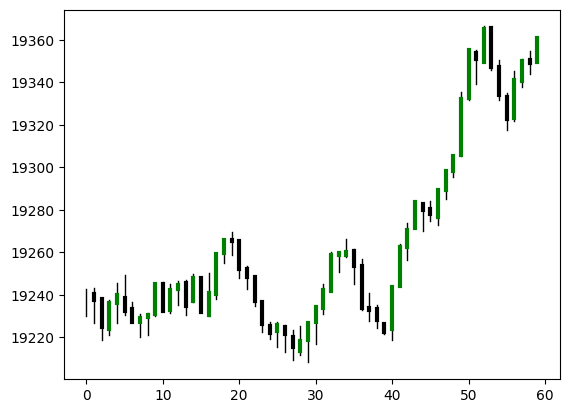

In [11]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
#step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
    plt.axhline(current_position.tp, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
    plt.axhline(current_order.tp, color = "orange")
print(current_position.direction, equity_L[-1])

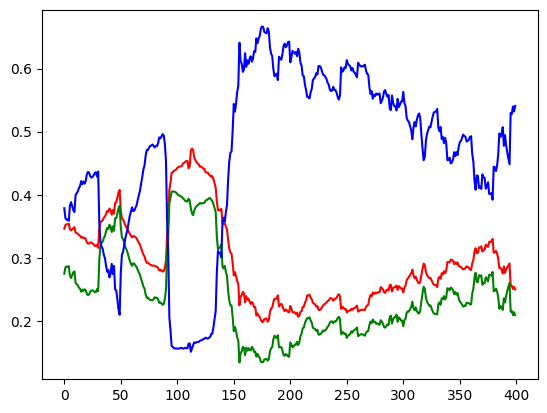

In [12]:
#plt.plot(outputs)
plt.plot([x[0] for x in outputs[-400:]], color="r")
plt.plot([x[1] for x in outputs[-400:]], color="g")
plt.plot([x[2] for x in outputs[-400:]], color="b")

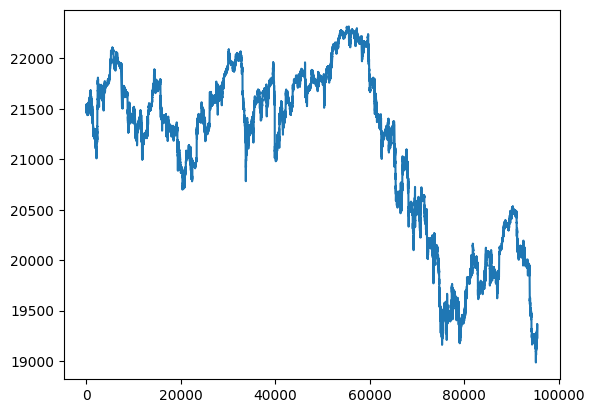

In [13]:
plt.plot([x.c for x in all_candles])

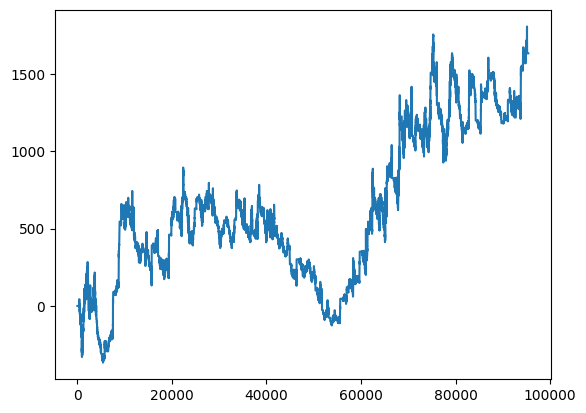

In [14]:
plt.plot(equity_L)

In [15]:
#plt.plot([x[1]-x[0] for x in outputs], color="b")